## Imports

In [1]:
# %pip install -U dataprep --user
# %pip install -U fuzzywuzzy --user

In [2]:
%matplotlib inline
# работа с даными
import numpy as np
import pandas as pd
import itertools

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt

#очистка данных
from fuzzywuzzy import fuzz, process

#разведка данных
from dataprep import eda

# предсказание и отбор признаков
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# масштабирование данных
from sklearn.preprocessing import StandardScaler

# валидация
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter("ignore")

C:\Users\Erik.K\AppData\Roaming\Python\Python38\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Функции

In [3]:
def col_by_bins(df, cols, p):
    "Функция разделения непрерывных или дискретных признаков на корзины с количеством значений не менее доли p"
    bins_cols = []
   
    for col in cols:

        if df[col].apply(type).mode()[0] == float:
            df[col] = df[col].fillna(df[col].median())

        bins_cols.append(col + '_bins' + str(p).replace('.', ''))

        bin_data = df[col].value_counts().sort_index()
        keys = []
        values = []

        k = 1
        i = 0

        while True:
            sums = bin_data.iloc[i:i+k].sum()
            if sums > df.shape[0] * p:
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                i = k + i
                k = 1
            else:
                k += 1
                
            if i + k > len(bin_data):
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                break

        for i, key in enumerate(keys):
            df.loc[df[col].isin(key), col + '_bins' + str(p).replace('.', '')] = i

    df[bins_cols] = df[bins_cols].astype(float)
    return df, bins_cols

def print_barhs_reg_mean(df, cols, target):
    "Функция вывода вертикальных столбцов со значениями value_counts,  target_shift, mean_target_shift"
    avr_target = df[target].mean()
    
    sum_shift = 0

    for col in cols:
        print()
        x = np.array((df.groupby(col).mean()[target] -
             avr_target).sort_index().index)
        y1 = df[col].value_counts().sort_index().values
        y2 = ((df.groupby(col).mean()[target] - avr_target) *
              df[col].value_counts() / df.shape[0]).sort_index().values
        y3 = (df.groupby(col).mean()[target]).sort_index().values - avr_target
        
        sum_shift = np.abs(y2).sum() / (len(x))
        
        print()
        print(col, ': Условная ценность = ', np.round(sum_shift,3))
        print()

        fig, axs = plt.subplots(1, 3, figsize=(21, 5))

        axs[0].barh(x, y1, height= 1 / np.sqrt(len(x)))
        axs[0].set_title('value_counts')
        axs[1].barh(x, y2, height= 1 / np.sqrt(len(x)))
        axs[1].set_title('target_shift')
        axs[2].barh(x, y3, height= 1 / np.sqrt(len(x)))
        axs[2].set_title('mean_target_shift')

        plt.show()
        print()


def order_values (df, cols, target, prefix):
    "Функция признака по среднему значения признака относительно значений таргета"
    temp = df.copy()
    for col in cols:
        values = df.groupby(col).mean()[target].sort_values()
        for i in range(len(values)):
            temp.loc[df[col] == values.index[i], col] = i
        df[col + '_' + prefix]  = temp[col]    
    return df

def L1_fs (
    cl, cl_helper, X_train, y_train, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    "Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации"
    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train[temp_features], y_train)

        imp2 = pd.Series(data = np.abs(cl_helper.coef_[0]), index = temp_features)
        impX = pd.Series(data = np.abs(cl_helper.coef_[1]), index = temp_features)
        imp1 = pd.Series(data = np.abs(cl_helper.coef_[2]), index = temp_features)

        imp = (imp1 + impX + imp2) / 3

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

def cl_fs(
    cl, cl_helper, X_train, y_train, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    "Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации"

    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train[temp_features], y_train)

        imp = pd.Series(data = cl_helper.feature_importances_, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        # print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

def permut_fs(
    cl, X_train, y_train, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    "Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации"

    temp_features = features
    new_feats = []

    for p in ps:

        cl.fit(X_train[temp_features], y_train)
        res = permutation_importance(cl, X_train[temp_features], y_train, n_repeats= 5, n_jobs = -1, random_state=random_state)
        imp = pd.Series(data = res.importances_mean, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

def voting_pred (cl1, cl2, cl3, X_train, y_train, X_sub, features):
    "Обучение и предсказание голосованием трёх алгоритмов с абсолютным приоритетом для миноритарного класса"
    cl1.fit(X_train[features], y_train)
    pred1 = cl1.predict(X_sub[features])

    cl2.fit(X_train[features], y_train)
    pred2 = cl2.predict(X_sub[features])

    cl3.fit(X_train[features], y_train)
    pred3 = cl3.predict(X_sub[features])

    predictions = pd.DataFrame(columns = ['cl1', 'cl2', 'cl3'])

    predictions['cl1'] = pred1
    predictions['cl2'] = pred2
    predictions['cl3'] = pred3

    sum = []
    sum3 = []
    sum4 = []

    for col in ['cl1', 'cl2', 'cl3']:
        if len(sum) == 0:
            sum = (predictions[col] == -1).astype(int) * 99999
        else:
            sum = sum + (predictions[col] == -1).astype(int) * 99999

        if len(sum3) == 0:
            sum3 = (predictions[col] == 3).astype(int)
        else:
            sum3 = sum3 + (predictions[col] == 3).astype(int)

        if len(sum4) == 0:
            sum4 = (predictions[col] == 4).astype(int)
        else:
            sum4 = sum4 + (predictions[col] == 4).astype(int)

    new_sub = pd.DataFrame(index = sum.index)

    new_sub['sum1'] = sum
    new_sub['sum3'] = sum3
    new_sub['sum4'] = sum4

    conds = ([
        (new_sub['sum1'] >= new_sub['sum3']) & (new_sub['sum1'] >= new_sub['sum4']),
        (new_sub['sum3'] > new_sub['sum1']) & (new_sub['sum3'] >= new_sub['sum4']),
        (new_sub['sum4'] > new_sub['sum1']) & (new_sub['sum4'] > new_sub['sum3']),
    ])

    choises = [-1, 3, 4]

    new_sub['Статус'] = np.select(conds, choises, default= np.NaN)

    return new_sub['Статус'] 

def voting_cv (cl1, cl2, cl3, X_train, y_train, cv_splitter,  features):
    "Обучение и предсказание голосованием трёх алгоритмов с абсолютным приоритетом для миноритарного класса"
    "для кросс валидации"
    
    pred1 = cross_val_predict(cl1, X_train[features], y_train, cv = cv_splitter)
    pred2 = cross_val_predict(cl2, X_train[features], y_train, cv = cv_splitter)
    pred3 = cross_val_predict(cl3, X_train[features], y_train, cv = cv_splitter)

    predictions = pd.DataFrame(columns = ['cl1', 'cl2', 'cl3'])

    predictions['cl1'] = pred1
    predictions['cl2'] = pred2
    predictions['cl3'] = pred3

    sum = []
    sum3 = []
    sum4 = []

    for col in ['cl1', 'cl2', 'cl3']:
        if len(sum) == 0:
            sum = (predictions[col] == -1).astype(int) * 99999
        else:
            sum = sum + (predictions[col] == -1).astype(int) * 99999

        if len(sum3) == 0:
            sum3 = (predictions[col] == 3).astype(int)
        else:
            sum3 = sum3 + (predictions[col] == 3).astype(int)

        if len(sum4) == 0:
            sum4 = (predictions[col] == 4).astype(int)
        else:
            sum4 = sum4 + (predictions[col] == 4).astype(int)

    new_sub = pd.DataFrame(index = sum.index)

    new_sub['sum1'] = sum
    new_sub['sum3'] = sum3
    new_sub['sum4'] = sum4

    conds = ([
        (new_sub['sum1'] >= new_sub['sum3']) & (new_sub['sum1'] >= new_sub['sum4']),
        (new_sub['sum3'] > new_sub['sum1']) & (new_sub['sum3'] >= new_sub['sum4']),
        (new_sub['sum4'] > new_sub['sum1']) & (new_sub['sum4'] > new_sub['sum3']),
    ])

    choises = [-1, 3, 4]

    new_sub['Статус'] = np.select(conds, choises, default= np.NaN)

    return new_sub['Статус'] 

## Data: загрузка и обзор

In [4]:
# загрузим данные и отметим значения из теста
train = pd.read_csv("train_dataset_train.csv")
train['test'] = -1
test = pd.read_csv("test_dataset_test.csv")
test['test'] = range(len(test))

df = pd.concat([train, test]).reset_index(drop = True)

df.head(3)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус,test
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3.0,-1
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4.0,-1
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4.0,-1


In [5]:
df.shape

(20275, 25)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275 entries, 0 to 20274
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                20275 non-null  int64  
 1   Код_группы        20275 non-null  int64  
 2   Год_Поступления   20275 non-null  int64  
 3   Пол               20265 non-null  object 
 4   Основания         20275 non-null  object 
 5   Изучаемый_Язык    19053 non-null  object 
 6   Дата_Рождения     20275 non-null  object 
 7   Уч_Заведение      18464 non-null  object 
 8   Где_Находится_УЗ  18234 non-null  object 
 9   Год_Окончания_УЗ  18358 non-null  float64
 10  Пособие           18783 non-null  float64
 11  Страна_ПП         19768 non-null  object 
 12  Регион_ПП         19367 non-null  object 
 13  Город_ПП          19618 non-null  object 
 14  Общежитие         20154 non-null  float64
 15  Наличие_Матери    20275 non-null  int64  
 16  Наличие_Отца      20275 non-null  float6

## EDA

<AxesSubplot:>

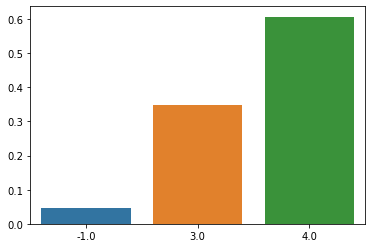

In [7]:
# баланс классов
balance = df['Статус'].value_counts(normalize=True)
sns.barplot(x = balance.index, y = balance.values)

In [8]:
balance

 4.0    0.607259
 3.0    0.347541
-1.0    0.045200
Name: Статус, dtype: float64

In [9]:
# представим таргет в виде вероятности по тренировочной выборке
df['Статус_prob'] = df['Статус'].map(balance)

In [7]:
# файл сохранён под именем DataPrep_Report_1
# report = eda.create_report(df)
# report.show_browser()

  0%|          | 0/2187 [00:00<?, ?it/s]

In [11]:
# файл сохранён под именем DataPrep_Report_2
# report = eda.plot_diff([df[df['test'] == -1], df[df['test'] > -1]])
# report.show_browser()

In [13]:
df.isna().sum().sort_values(ascending = False)

Статус_prob         6691
Статус              6691
Где_Находится_УЗ    2041
Год_Окончания_УЗ    1917
Уч_Заведение        1811
Пособие             1492
Изучаемый_Язык      1222
Регион_ПП            908
Город_ПП             657
Страна_Родители      656
Страна_ПП            507
Иностранец           440
Село                 123
Общежитие            121
Пол                   10
test                   0
Год_Поступления        0
СрБаллАттестата        0
КодФакультета          0
Дата_Рождения          0
Опекунство             0
Основания              0
Наличие_Отца           0
Наличие_Матери         0
Код_группы             0
ID                     0
dtype: int64

In [14]:
df.nunique().sort_values(ascending = False)

ID                  20275
test                 6692
Дата_Рождения        5960
Уч_Заведение         4709
Код_группы           4233
Где_Находится_УЗ     2710
Город_ПП             2244
СрБаллАттестата       527
Регион_ПП             240
Год_Окончания_УЗ       45
Страна_ПП              26
Страна_Родители        23
КодФакультета          20
Год_Поступления        20
Изучаемый_Язык          8
Основания               6
Пол                     4
Статус                  3
Статус_prob             3
Село                    2
Иностранец              2
Опекунство              2
Наличие_Матери          2
Общежитие               2
Наличие_Отца            2
Пособие                 1
dtype: int64

### Nans

In [15]:
nan_cols = df.isna().sum()[df.isna().sum() > 0].index.drop(['Статус', 'Статус_prob'])
df_nans = df[nan_cols].isna().astype(int)

df_nans.columns = df_nans.columns + 'isNaN'

df_nans['nans_sum'] = df_nans.sum(axis = 1)

df_nans.head()

,ПолisNaN,Изучаемый_ЯзыкisNaN,Уч_ЗаведениеisNaN,Где_Находится_УЗisNaN,Год_Окончания_УЗisNaN,ПособиеisNaN,Страна_ППisNaN,Регион_ППisNaN,Город_ППisNaN,ОбщежитиеisNaN,Страна_РодителиisNaN,СелоisNaN,ИностранецisNaN,nans_sum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df = pd.concat([df, df_nans], axis = 1)

In [ ]:
# print_barhs_reg_mean(df, df_nans.columns, 'Статус_prob')

### ID

In [ ]:
# eda.plot(df, 'ID')

In [19]:
df['ID_edited'] = df['ID']
df['ID_93277'] = np.where(df['ID'] > 93277, 1, 0)
df.loc[df['ID_edited'] > 93277, 'ID'] = 93277 + df[df['ID'] > 93277].reset_index().index
df['ID_60k-'] = np.where(df['ID_edited'] < 60000, 1, 0)
df['ID_80k+'] = np.where(df['ID_edited'] >= 80000, 1, 0)



ID_edited_bins01 : Условная ценность =  0.004



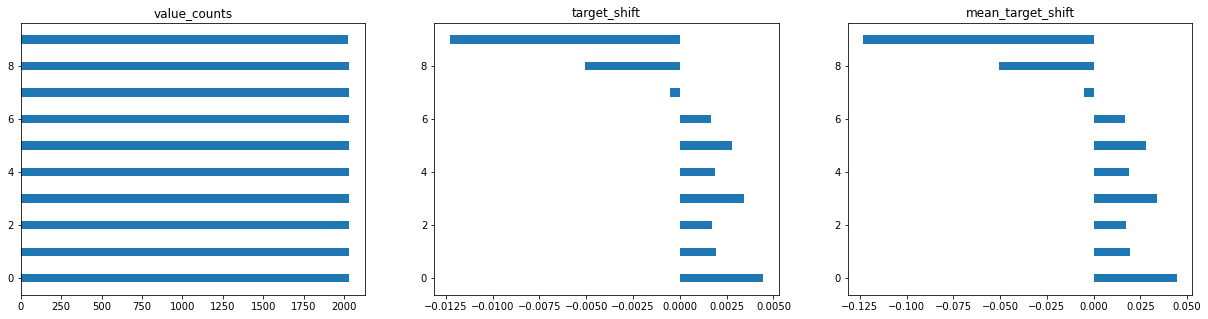

In [20]:
df, bins = col_by_bins (df, ['ID_edited'], 0.1)
print_barhs_reg_mean(df, bins, 'Статус_prob')

### СрБаллАттестата

In [ ]:
# eda.plot(df, 'СрБаллАттестата')



СрБаллАттестата_bins005 : Условная ценность =  0.001



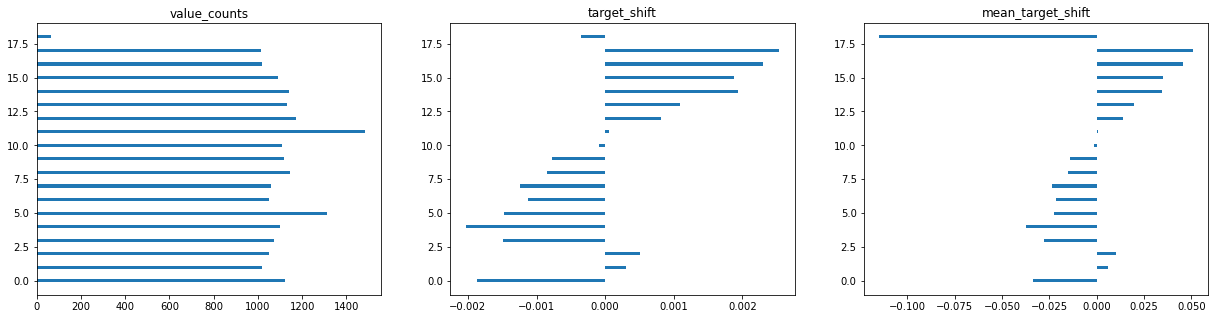

In [22]:
df, bins = col_by_bins(df, ['СрБаллАттестата'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [23]:
df['СрБаллАттестата_edited'] = df['СрБаллАттестата']

df['СрБаллАттестата_0_flag'] = 0
df.loc[df['СрБаллАттестата'] == 0, 'СрБаллАттестата_0_flag'] = -1
df.loc[df['СрБаллАттестата'] == 0, 'СрБаллАттестата_edited'] = -1

# переведём в 5ти бальную систему
df['СрБаллАттестата_5000_flag'] = 0
df.loc[(df['СрБаллАттестата_edited'] >= 3000) & (df['СрБаллАттестата_edited'] <= 5000), 'СрБаллАттестата_5000_flag'] = 1
df.loc[(df['СрБаллАттестата_edited'] >= 3000) & (df['СрБаллАттестата_edited'] <= 5000), 'СрБаллАттестата_edited'] = df.loc[(df['СрБаллАттестата_edited'] >= 3000) & (df['СрБаллАттестата_edited'] <= 5000), 'СрБаллАттестата_edited'] / 1000

# переведём в 100 бальную систему
df['СрБаллАттестата_10000_flag'] = 0
df.loc[(df['СрБаллАттестата_edited'] >= 1000), 'СрБаллАттестата_10000_flag'] = 1
df.loc[(df['СрБаллАттестата_edited'] >= 1000), 'СрБаллАттестата_edited'] = df.loc[df['СрБаллАттестата_edited'] >= 1000, 'СрБаллАттестата_edited'] / 100
df['СрБаллАттестата_1000_flag'] = 0
df.loc[df['СрБаллАттестата_edited'] >= 400, 'СрБаллАттестата_1000_flag'] = 1
df.loc[df['СрБаллАттестата_edited'] >= 400, 'СрБаллАттестата_edited'] = (df.loc[df['СрБаллАттестата_edited'] >= 400, 'СрБаллАттестата_edited']) / 10
df['СрБаллАттестата_5_flag'] = 0
df.loc[((df['СрБаллАттестата_edited'] >= 3) & (df['СрБаллАттестата_edited'] <= 5)), 'СрБаллАттестата_5_flag'] = 1
df.loc[((df['СрБаллАттестата_edited'] >= 3) & (df['СрБаллАттестата_edited'] <= 5)), 'СрБаллАттестата_edited'] = df.loc[((df['СрБаллАттестата_edited'] >= 3) & (df['СрБаллАттестата_edited'] <= 5)), 'СрБаллАттестата_edited'] * 10



СрБаллАттестата_edited_bins01 : Условная ценность =  0.002



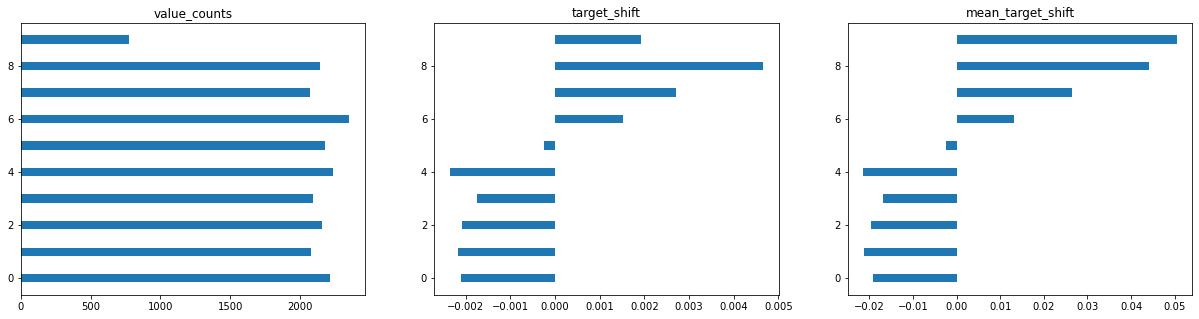

In [24]:
df, bins = col_by_bins(df, ['СрБаллАттестата_edited'], 0.1)
print_barhs_reg_mean(df, bins, 'Статус_prob')

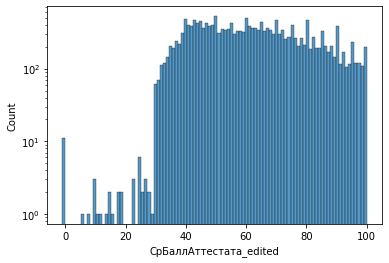

In [25]:
sns.histplot(df['СрБаллАттестата_edited'], bins = 100)
plt.yscale('log')

### Код_группы

In [26]:
# eda.plot(df, 'Код_группы')

In [27]:
# eda.plot(df, 'Год_Поступления', 'ID')

In [28]:
df['Код_группы_12k-'] = np.where(df['Код_группы'] < 12800, 1, 0)
df['Код_группы_16k+'] = np.where(df['Код_группы'] >= 16500, 1, 0)



Код_группы_bins005 : Условная ценность =  0.003



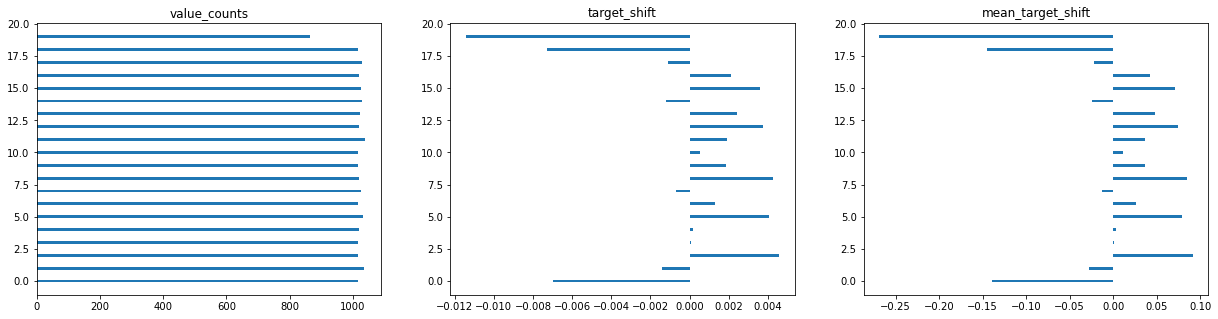

In [29]:
df, bins = col_by_bins (df, ['Код_группы'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')



Код_группы_bins005_ord_cat : Условная ценность =  0.003



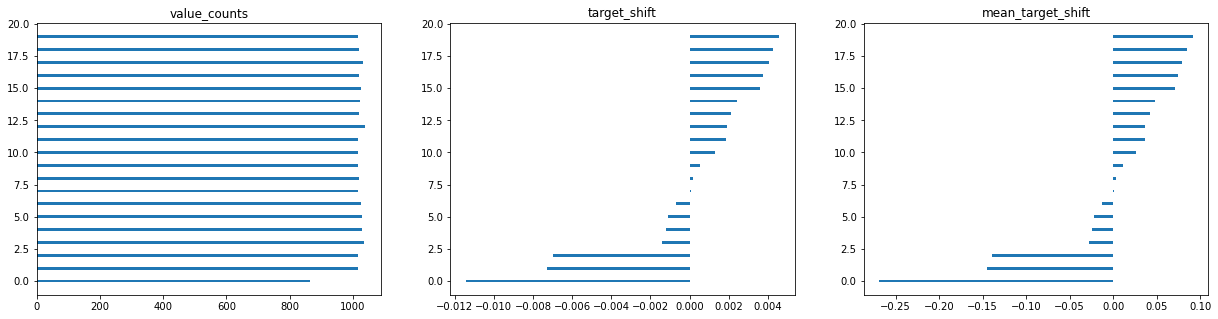

In [30]:
df = order_values (df, ['Код_группы_bins005'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Код_группы_bins005_ord_cat'], 'Статус_prob')

### Год_Поступления

In [31]:
# eda.plot(df, 'Год_Поступления')

In [32]:
df['Год_Поступления_edited'] = df['Год_Поступления']
df.loc[df['Год_Поступления'] == 2212, 'Год_Поступления_edited'] = 2012

df['Год_поступления_2009-'] = np.where(df['Год_Поступления_edited'] < 2009, 1, 0)
df.loc[df['Год_Поступления_edited'] < 2009, 'Год_Поступления_edited'] = 2009

df['Год_поступления_2011-'] = np.where(df['Год_Поступления_edited'] < 2011, 1, 0)
df.loc[df['Год_Поступления_edited'] < 2011, 'Год_Поступления_edited'] = 2011

In [33]:
df['Год_Поступления_edited'].value_counts()

2015    3525
2014    3467
2016    3385
2013    3098
2017    2174
2012    2032
2018    1691
2019     693
2011     123
2020      87
Name: Год_Поступления_edited, dtype: int64



Год_Поступления_edited_bins005 : Условная ценность =  0.005



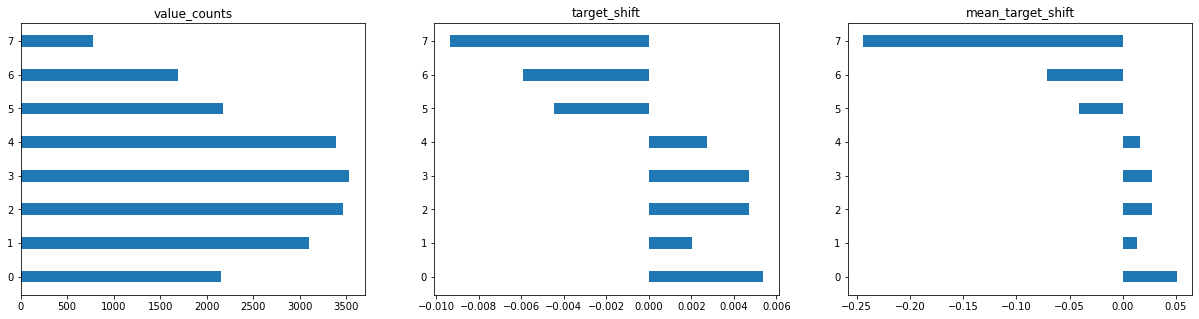

In [34]:
df, bins = col_by_bins (df, ['Год_Поступления_edited'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

### Пол

In [35]:
# eda.plot(df, 'Пол')

In [36]:
df['Пол'] = df['Пол'].fillna('isNaN')
df.loc[df['Пол'] == 'муж', 'Пол'] = 'Муж'
df.loc[df['Пол'] == 'жен', 'Пол'] = 'Жен'



Пол : Условная ценность =  0.008



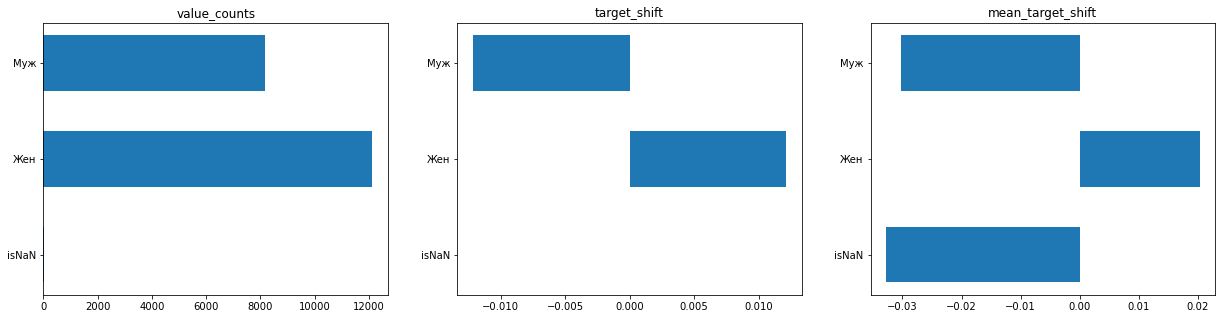

In [37]:
temp, bins = col_by_bins (df, ['Пол'], 0.1)
print_barhs_reg_mean(temp, ['Пол'], 'Статус_prob')

In [38]:
df.loc[df['Пол'] == 'isNaN', 'Пол'] = 'Муж'



Пол_ord_cat : Условная ценность =  0.012



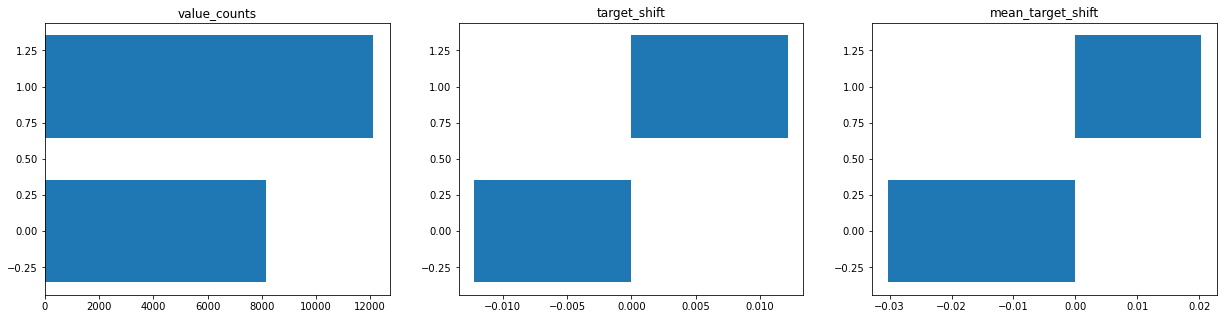

In [39]:
df = order_values (df, ['Пол'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Пол_ord_cat'], 'Статус_prob')

### Основания

In [40]:
# eda.plot(df, 'Основания')



Основания : Условная ценность =  nan



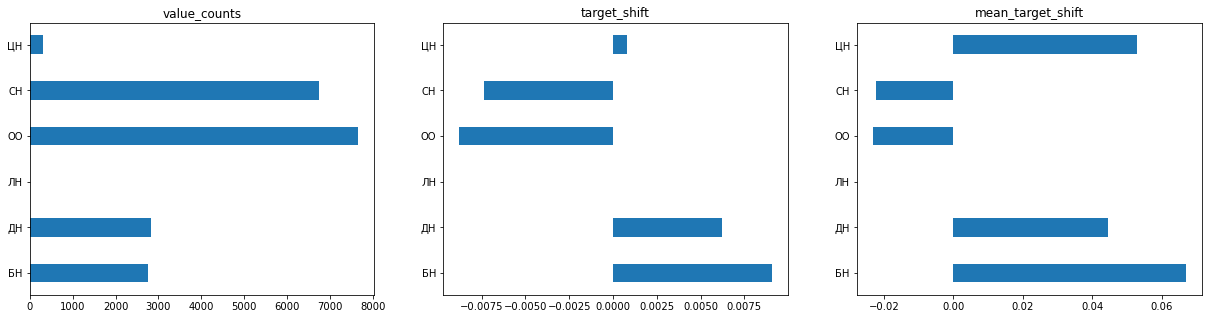

In [41]:
temp, bins = col_by_bins (df, ['Основания'], 0.05)
print_barhs_reg_mean(df, ['Основания'], 'Статус_prob')

In [42]:
# СН - специальный набор  
# ЦН - целевой набор  
# БН - бюджетный набор  
# ОО - общие основания  
# ДН - дополнительный прием  

df.loc[df['Основания'] == 'ЛН', 'Основания'] = 'ОО'



Основания : Условная ценность =  0.006



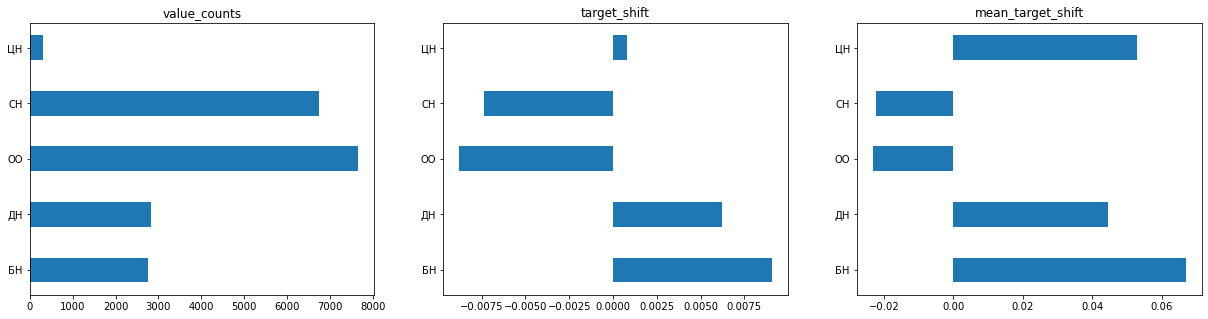

In [43]:
print_barhs_reg_mean(df, ['Основания'], 'Статус_prob')



Основания_ord_cat : Условная ценность =  0.006



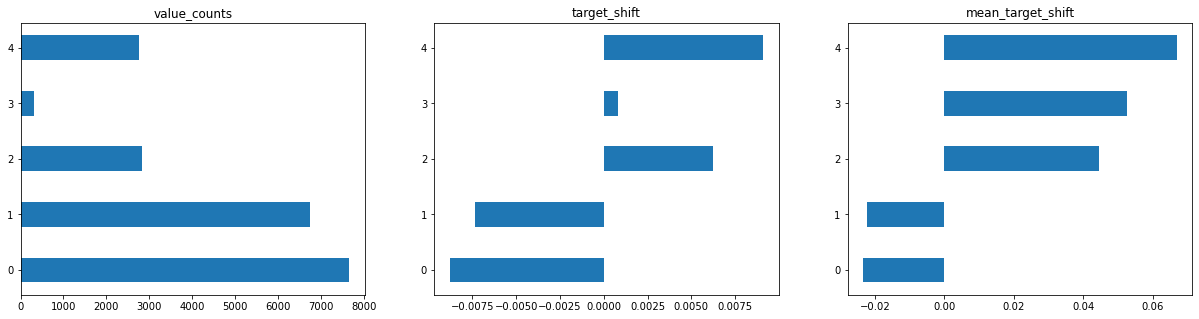

In [44]:
df = order_values (df, ['Основания'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Основания_ord_cat'], 'Статус_prob')

In [45]:
df['Основания_bin'] = np.where(df['Основания_ord_cat'].isin([2,3,4]), 1, 0)

### Изучаемый_Язык

In [46]:
# eda.plot(df, col)

In [47]:
df['Изучаемый_Язык'] = df['Изучаемый_Язык'].fillna('isNaN')
df['Изучаемый_Язык'].unique()

array(['Английский язык', 'isNaN', 'Немецкий язык', 'Французский язык',
       'Русский язык', 'Иностранный язык (Английский)',
       'Иностранный язык (Немецкий)', 'Англиийский',
       'Английский, немецкий языки'], dtype=object)

In [48]:
df['Изучаемый_Язык'] = df['Изучаемый_Язык'].str.replace('язык', '').str.replace('Иностранный', '').str.replace(' ', '').str.replace(')', '').str.replace('(', '')
df.loc[df['Изучаемый_Язык'] == 'Англиийский', 'Изучаемый_Язык'] = 'Английский'

In [49]:
df['Изучаемый_Язык'].unique()

array(['Английский', 'isNaN', 'Немецкий', 'Французский', 'Русский',
       'Английский,немецкийи'], dtype=object)

In [50]:
# eda.plot(df, 'Изучаемый_Язык')

In [51]:
df.loc[~df['Изучаемый_Язык'].isin(['Английский', 'Немецкий']), 'Изучаемый_Язык'] = 'Другой'



Изучаемый_Язык : Условная ценность =  0.002



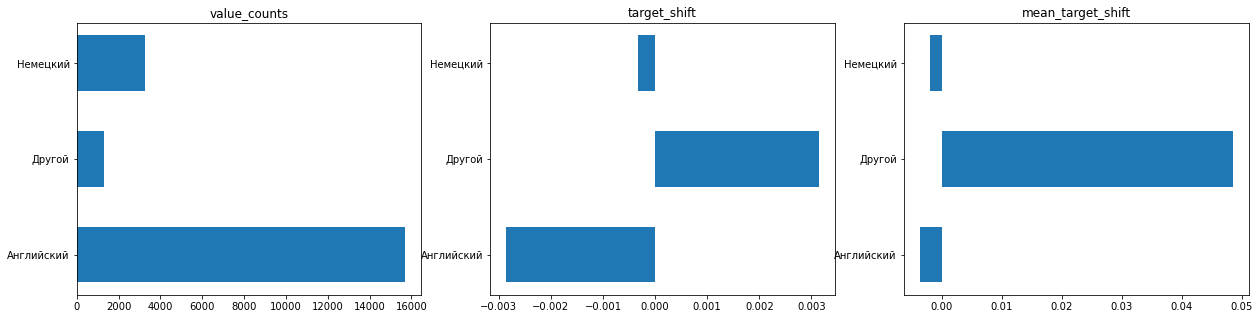

In [52]:
print_barhs_reg_mean(df, ['Изучаемый_Язык'], 'Статус_prob')



Изучаемый_Язык_ord_cat : Условная ценность =  0.002



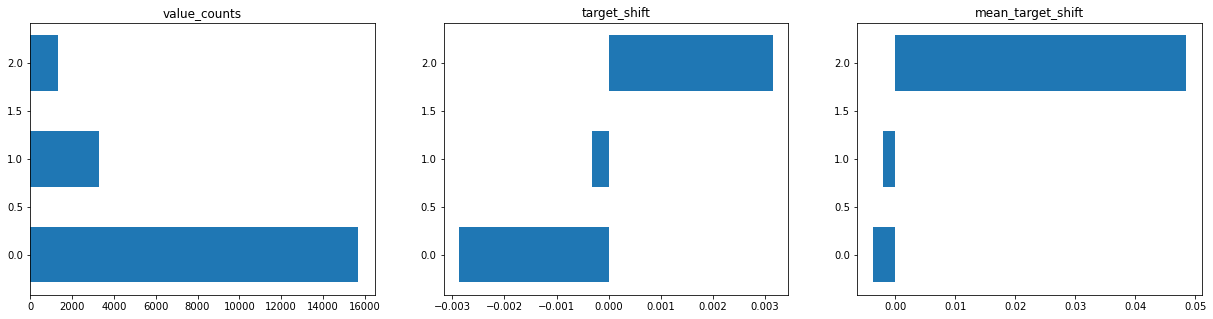

In [53]:
# temp, bins = col_by_bins (df, ['Основания'], 0.05)
df = order_values (df, ['Изучаемый_Язык'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Изучаемый_Язык' + '_ord_cat'], 'Статус_prob')

### Дата_Рождения

In [54]:
df['год_рождения'] = pd.DatetimeIndex(df['Дата_Рождения']).year
df['месяц_рождения'] = pd.DatetimeIndex(df['Дата_Рождения']).month
df['день_рождения'] = pd.DatetimeIndex(df['Дата_Рождения']).day

In [ ]:
# eda.plot(df, 'год_рождения')



год_рождения_bins0025 : Условная ценность =  0.002



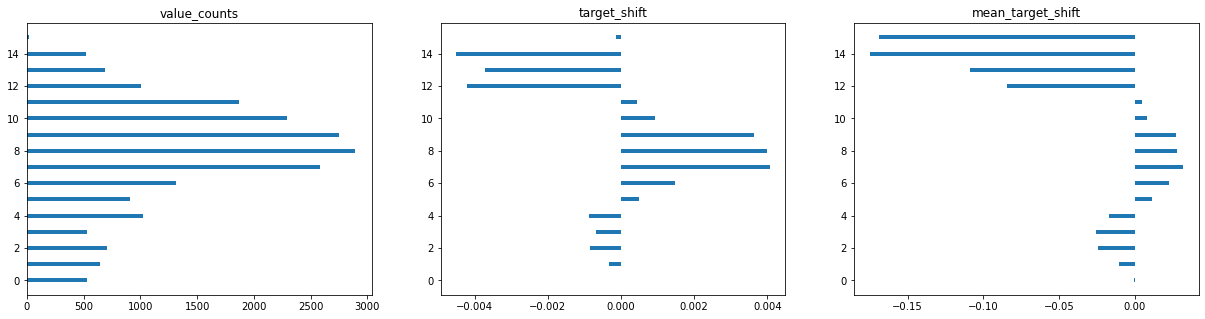

In [56]:
temp, bins = col_by_bins (df, ['год_рождения'], 0.025)
print_barhs_reg_mean(temp, bins, 'Статус_prob')

In [57]:
df['Год_рождения_young'] = np.where(df[bins[0]].isin([11,12,13,14]), 1, 0)

In [58]:
df['год_рождения_edited'] = df['год_рождения']

df.loc[df['год_рождения_edited'] > 2003, 'год_рождения_edited'] = 2003
df.loc[df['год_рождения_edited'] < 1957, 'год_рождения_edited'] = 1957

In [59]:
df['год_рождения_edited_log'] = df['год_рождения_edited'] - df['год_рождения_edited'].min()
df['год_рождения_edited_log'] = np.log(df['год_рождения_edited_log'].max() - df['год_рождения_edited_log'] + 1)

In [60]:
df['дата_рождения_нараст'] = df['год_рождения'] * 365 + df['месяц_рождения'] * 30 + df['день_рождения']

In [61]:
df['дата_рождения_нараст_edited'] = df['дата_рождения_нараст']

df.loc[df['дата_рождения_нараст_edited'] < 719200, 'дата_рождения_нараст_edited'] = 719200

In [62]:
df['дата_рождения_нараст_edited_log'] = df['дата_рождения_нараст_edited'] - df['дата_рождения_нараст_edited'].min()
df['дата_рождения_нараст_edited_log'] = np.log(df['дата_рождения_нараст_edited'].max() - df['дата_рождения_нараст_edited'] + 1)



год_рождения_bins005 : Условная ценность =  0.003



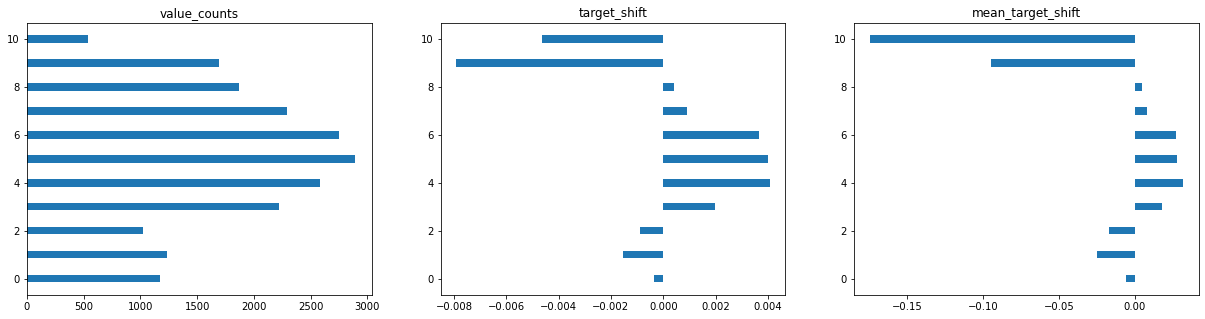

In [63]:
df, bins = col_by_bins (df, ['год_рождения'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

### Год_Окончания_УЗ

In [ ]:
# eda.plot(df, 'Год_Окончания_УЗ')

In [65]:
df['Год_Окончания_УЗ_edited'] = df['Год_Окончания_УЗ']
df.loc[df['Год_Окончания_УЗ_edited'] == 2212, 'Год_Окончания_УЗ_edited'] = 2012

In [66]:
df['Год_Окончания_УЗ_1979-'] = np.where(df['Год_Окончания_УЗ_edited'] < 1979, 1, 0)
df.loc[df['Год_Окончания_УЗ_edited'] < 1979, 'Год_Окончания_УЗ_edited'] = 1979

In [67]:
df['Год_Окончания_УЗ_edited_log'] = df['Год_Окончания_УЗ_edited'] - df['Год_Окончания_УЗ_edited'].min()
df['Год_Окончания_УЗ_edited_log'] = np.log(df['Год_Окончания_УЗ_edited_log'].max() - df['Год_Окончания_УЗ_edited_log'] + 1)

In [ ]:
# eda.plot(df, 'Год_Окончания_УЗ_edited_log')



Год_Окончания_УЗ_edited_bins005 : Условная ценность =  0.004



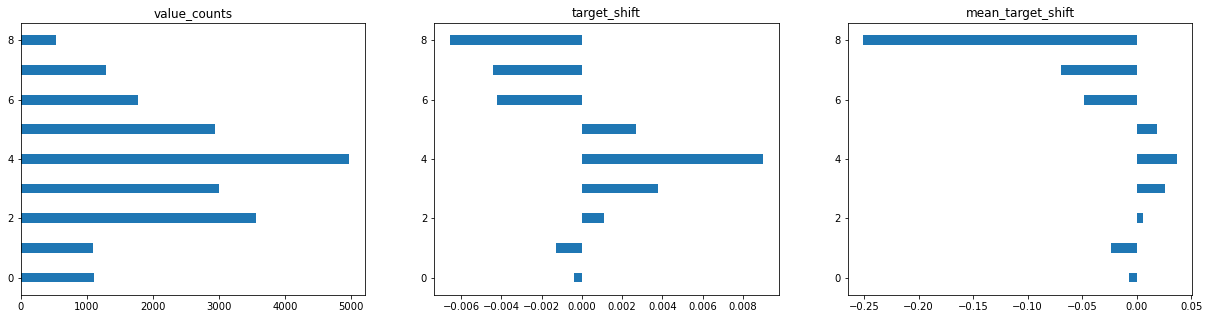

In [69]:
df, bins = col_by_bins (df, ['Год_Окончания_УЗ_edited'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [70]:
df['Год_Окончания_УЗ_bin'] = np.where(temp[bins[0]].isin([8,7,6]), 1, 0)

### окон_пост

In [71]:
df['пост_окон'] = df['Год_Поступления'] - df['Год_Окончания_УЗ']

In [ ]:
# eda.plot(df, 'пост_окон')

In [73]:
df.loc[df['пост_окон'] < 0, 'пост_окон'] = np.NaN

df['пост_окон_log'] = np.log(df['пост_окон'] + 1)



пост_окон_bins005 : Условная ценность =  0.003



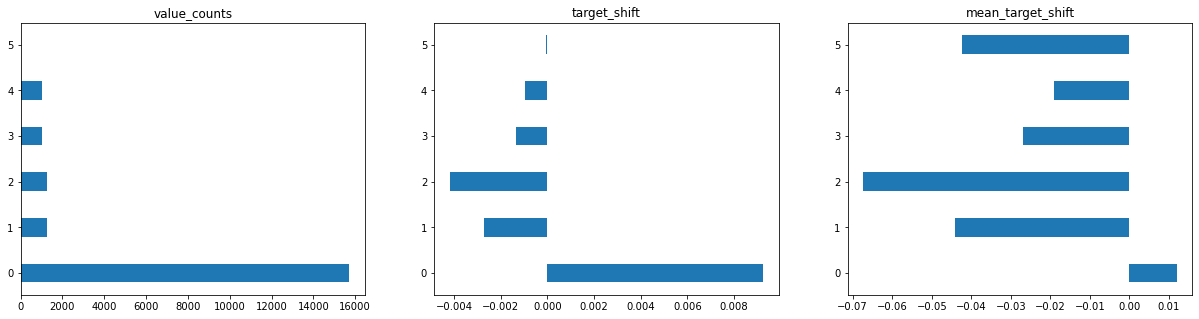

In [74]:
df, bins = col_by_bins (df, ['пост_окон'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [75]:
df['пост_окон_bin'] = np.where(df[bins[0]].isin([0]), 1, 0)

### возраст_окон

In [76]:
df['возраст_окон'] = df['Год_Окончания_УЗ'] - df['год_рождения']

In [ ]:
# eda.plot(df, 'возраст_окон')

In [78]:
df.loc[df['возраст_окон'] < 15, 'возраст_окон'] = np.NaN



возраст_окон_bins01 : Условная ценность =  0.002



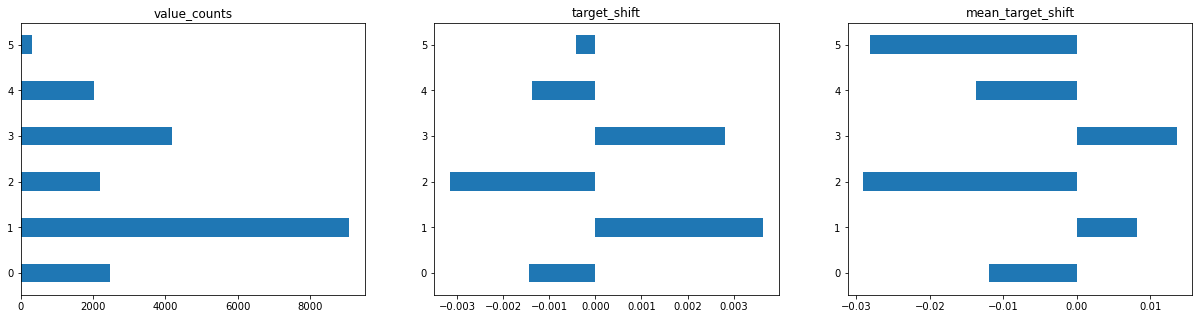

In [79]:
df, bins = col_by_bins (df, ['возраст_окон'], 0.1)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [80]:
df['возраст_окон_log'] = df['возраст_окон'] - df['возраст_окон'].min()
df['возраст_окон_log'] = np.log(df['возраст_окон_log'] + 1)

In [81]:
# eda.plot(df, 'возраст_окон_log')

<AxesSubplot:xlabel='возраст_окон_log', ylabel='Count'>

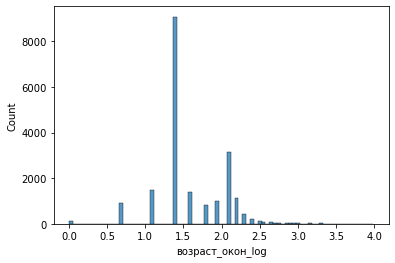

In [82]:
sns.histplot(df['возраст_окон_log'])

In [83]:
df['возраст_окон_log_bin'] = np.where(df['возраст_окон_log'] > 1.8, 1 , 0)

### возраст_пост

In [84]:
df['возраст_пост'] = df['Год_Поступления'] - df['год_рождения']

In [ ]:
# eda.plot(df, 'возраст_пост')

In [86]:
df.loc[df['возраст_пост'] < 15, 'возраст_пост'] = np.NaN



возраст_пост_bins01 : Условная ценность =  0.002



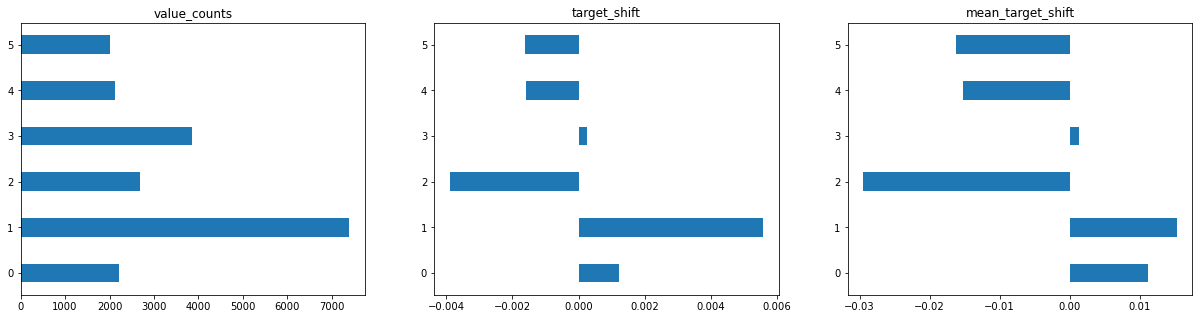

In [87]:
df, bins = col_by_bins (df, ['возраст_пост'], 0.1)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [88]:
df['возраст_пост_log'] = df['возраст_пост'] - df['возраст_пост'].min()
df['возраст_пост_log'] = np.log(df['возраст_пост_log'] + 1)

In [ ]:
# eda.plot(df, 'возраст_пост_log')

In [90]:
df['возраст_пост_log_bin'] = np.where(df['возраст_пост_log'] > 1.85, 1 , 0)

### Наличие_Матери, Отца, Полнота семьи

In [91]:
# eda.plot(df, 'Наличие_Матери')

In [92]:
# eda.plot(df, 'Наличие_Отца')

In [93]:
conds = [
    (df['Наличие_Матери'] == 0) & (df['Наличие_Отца'] == 0), 
    (df['Наличие_Матери'] == 1) & (df['Наличие_Отца'] == 1)
    ]
choises = [0, 2]

df['полнота_семьи'] = np.select(conds, choises, default=1)



полнота_семьи : Условная ценность =  0.0



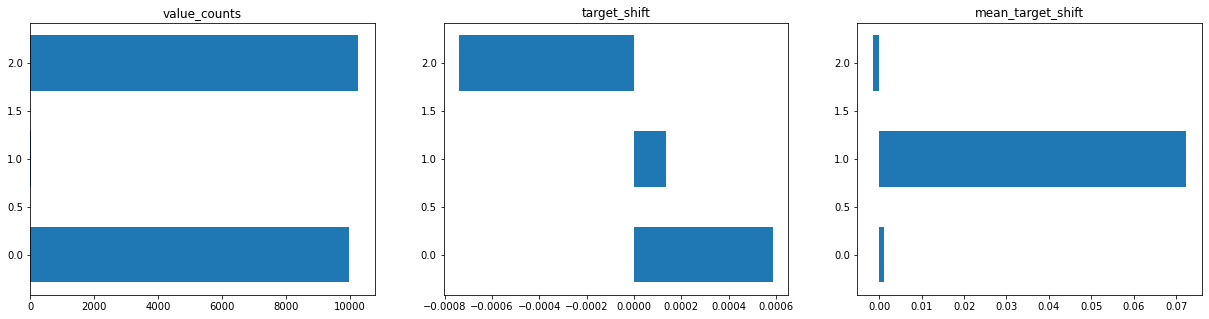

In [94]:
print_barhs_reg_mean(df, ['полнота_семьи'], 'Статус_prob')

In [95]:
df['полнота_семьи_1_bin'] = np.where(df['полнота_семьи'] == 1, 1, 0)
df['полнота_семьи'] = np.where(df['полнота_семьи'] == 2, 1, 0)

### Опекунство

In [96]:
# eda.plot(df, 'Опекунство')



Опекунство : Условная ценность =  0.0



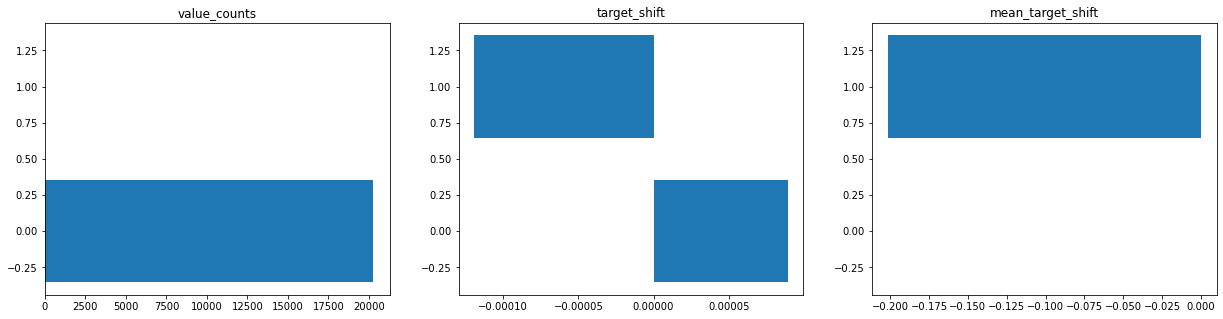

In [97]:
print_barhs_reg_mean(df, ['Опекунство'], 'Статус_prob')

### Страна_Родители

In [98]:
# eda.plot(df, 'Страна_Родители')

In [99]:
df['Страна_Родители'] = df['Страна_Родители'].str.lower().str.replace(' ', '_')
df['Страна_Родители'].unique()

array(['россия', nan, 'кыргызстан', 'казахстан', 'китай', 'таджикистан',
       'киргизия', 'туркменистан', 'германия', 'кыргызская_республика',
       'армения', 'республика_молдова', 'республика_таджикистан',
       'нигерия', 'узбекистан', 'республика_казахстан', 'монголия',
       'украина', 'кнр', 'афганистан', 'чеченская_республика', 'кыргызия'],
      dtype=object)

In [100]:
countries_mapping = dict(
    киргизия = 'кыргызстан', 
    кыргызия = 'кыргызстан', 
    кыргызская_республика = 'кыргызстан',
    казахстан_респ = 'казахстан', 
    казахстан_вко = 'казахстан', 
    республика_казахстан = 'казахстан',
    таджикистан_респ = 'таджикистан',
    республика_таджикистан = 'таджикистан',
    кнр = 'китай'

    )
countries_mapping.keys()

df.loc[df['Страна_Родители'].isin(countries_mapping.keys()), 'Страна_Родители'] = df.loc[df['Страна_Родители'].isin(countries_mapping.keys()), 'Страна_Родители'].map(countries_mapping)

In [101]:
df['Страна_Родители'].unique()

array(['россия', nan, 'кыргызстан', 'казахстан', 'китай', 'таджикистан',
       'туркменистан', 'германия', 'армения', 'республика_молдова',
       'нигерия', 'узбекистан', 'монголия', 'украина', 'афганистан',
       'чеченская_республика'], dtype=object)

In [102]:
df['Страна_Родители'] = df['Страна_Родители'].fillna('isNaN')

In [103]:
df['Страна_Родители'].value_counts()

россия                  18314
казахстан                 755
isNaN                     656
китай                     230
таджикистан               181
кыргызстан                113
туркменистан                7
узбекистан                  6
армения                     3
монголия                    3
афганистан                  2
германия                    1
республика_молдова          1
нигерия                     1
украина                     1
чеченская_республика        1
Name: Страна_Родители, dtype: int64



Страна_Родители : Условная ценность =  nan



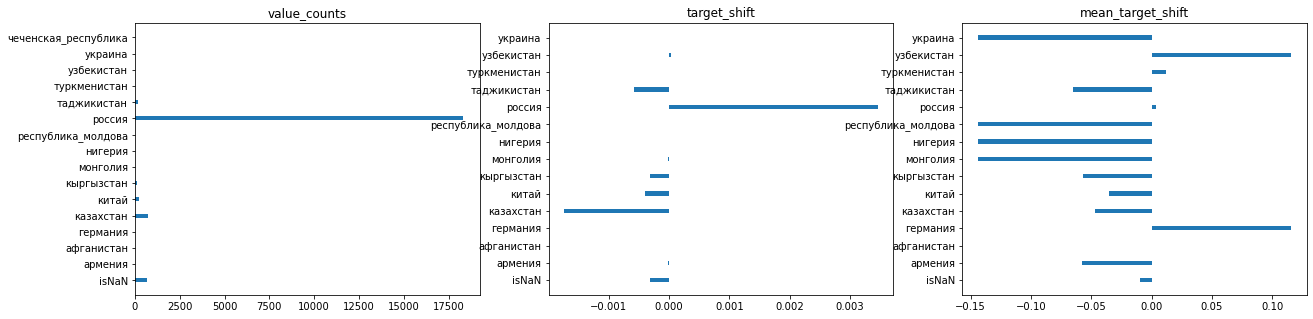

In [104]:
print_barhs_reg_mean(df, ['Страна_Родители'], 'Статус_prob')

In [105]:
df.loc[~df['Страна_Родители'].isin(['россия', 'казахстан', 'китай','кыргызстан','таджикистан']), 'Страна_Родители'] = 'Другое'



Страна_Родители : Условная ценность =  0.001



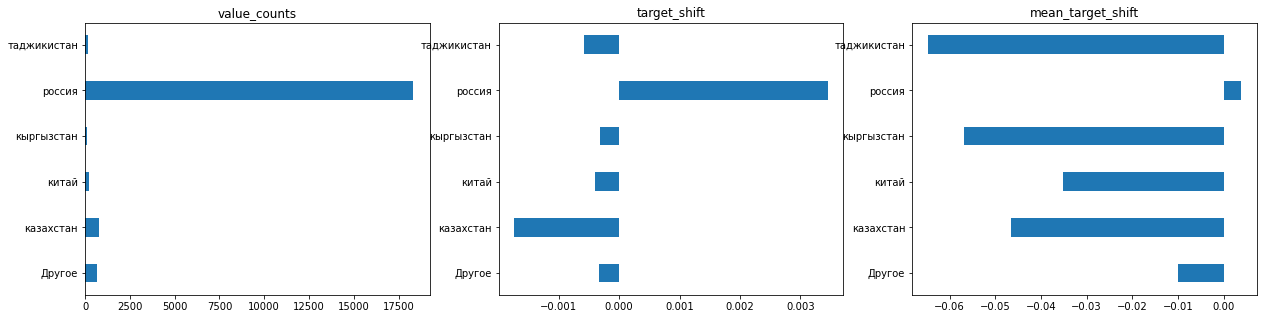

In [106]:
print_barhs_reg_mean(df, ['Страна_Родители'], 'Статус_prob')



Страна_Родители_ord_cat : Условная ценность =  0.001



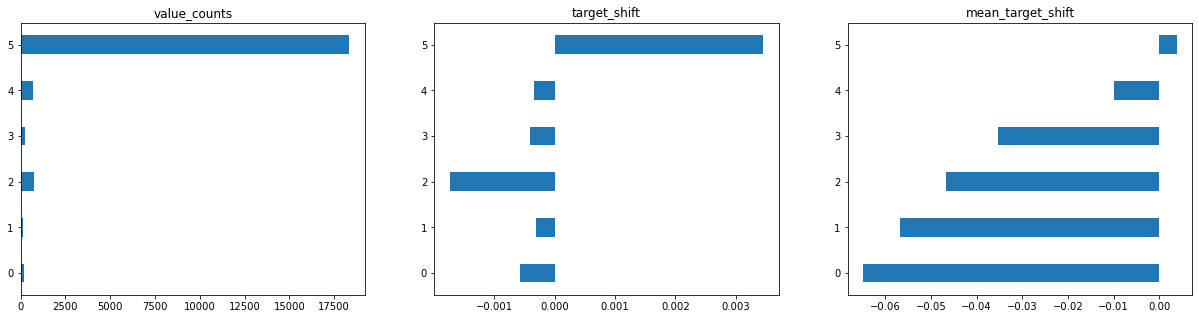

In [107]:
df = order_values (df, ['Страна_Родители'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Страна_Родители_ord_cat'], 'Статус_prob')

In [108]:
df['Cтрана_Родители_Россия'] = np.where(df['Страна_Родители'] == 'россия', 1, 0)

### Пособие

In [109]:
df['Пособие'] = df['Пособие'].fillna(1)



Пособие : Условная ценность =  0.005



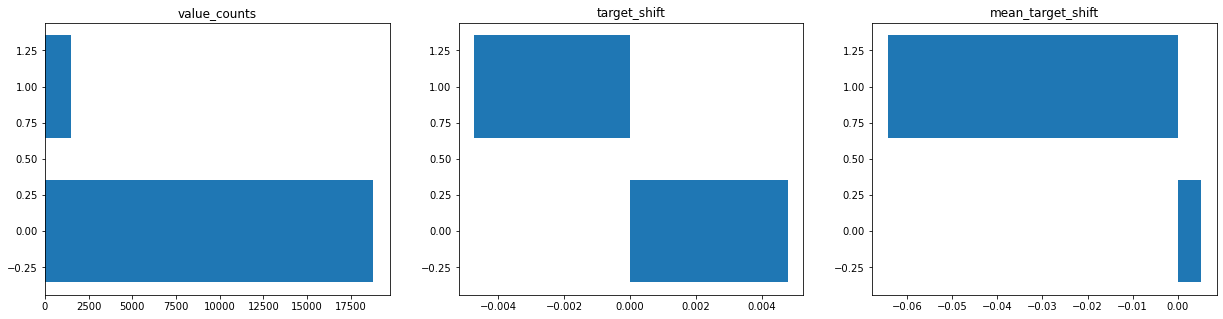

In [110]:
print_barhs_reg_mean(df, ['Пособие'], 'Статус_prob')

### Общежитие

In [111]:
# eda.plot(df, 'Общежитие')

In [112]:
df['Общежитие'] = df['Общежитие'].fillna(-1)



Общежитие : Условная ценность =  0.002



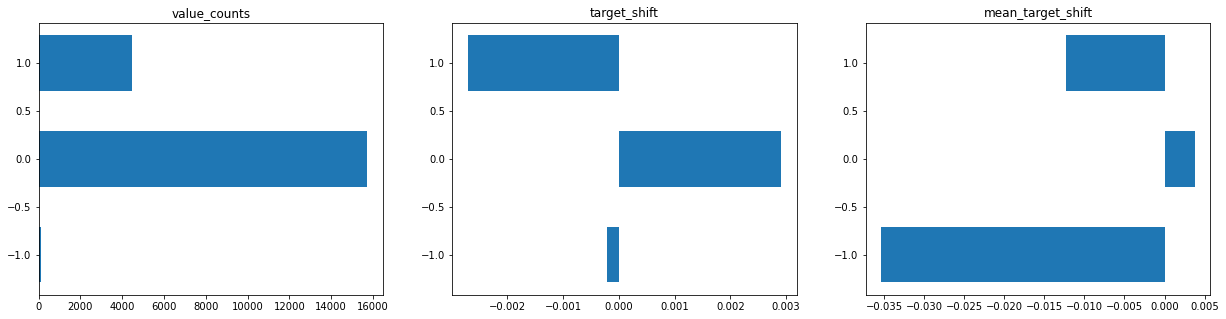

In [113]:
print_barhs_reg_mean(df, ['Общежитие'], 'Статус_prob')

In [114]:
df.loc[df['Общежитие'] == -1, 'Общежитие'] = 1

### Село

In [115]:
# eda.plot(df, 'Село')

In [116]:
df['Село'] = df['Село'].fillna(-1)



Село : Условная ценность =  0.0



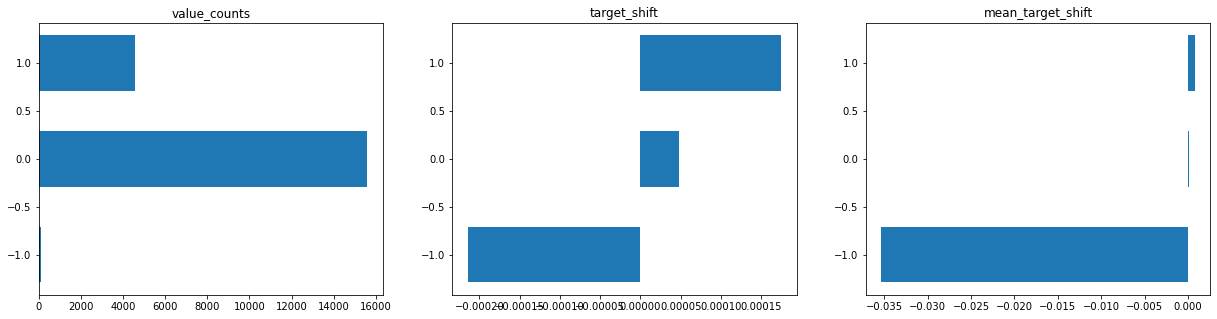

In [117]:
print_barhs_reg_mean(df, ['Село'], 'Статус_prob')

In [118]:
df.loc[df['Село'] == -1, 'Село'] = 0

### Иностранец

In [119]:
# eda.plot(df, 'Иностранец')

In [120]:
df['Иностранец'] = df['Иностранец'].fillna(-1)



Иностранец : Условная ценность =  0.003



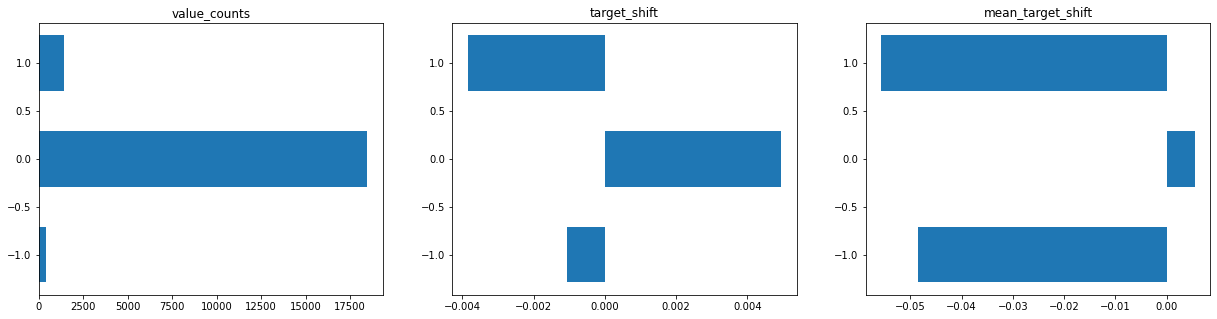

In [121]:
print_barhs_reg_mean(df, ['Иностранец'], 'Статус_prob')

In [122]:
df.loc[df['Иностранец'] == -1, 'Иностранец'] = 1

### КодФакультета

In [123]:
# eda.plot(df, 'КодФакультета')



КодФакультета_bins0055 : Условная ценность =  0.002



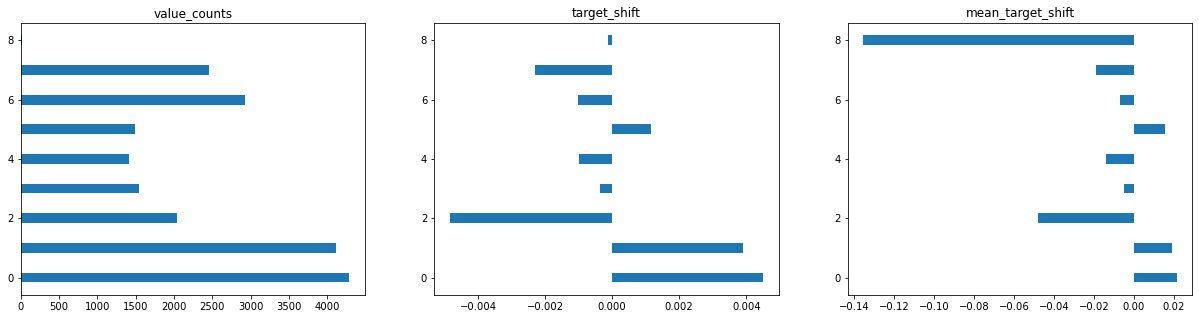

In [124]:
df, bins = col_by_bins (df, ['КодФакультета'], 0.055)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [125]:
df['КодФакультета_bin_1'] = np.where(df[bins[0]].isin([0,1]), 1, 0)
df['КодФакультета_bin_2'] = np.where(df[bins[0]].isin([2]), 1, 0)

In [126]:
# eda.plot(df, bins[0])



КодФакультета_bins0055_ord_cat : Условная ценность =  0.002



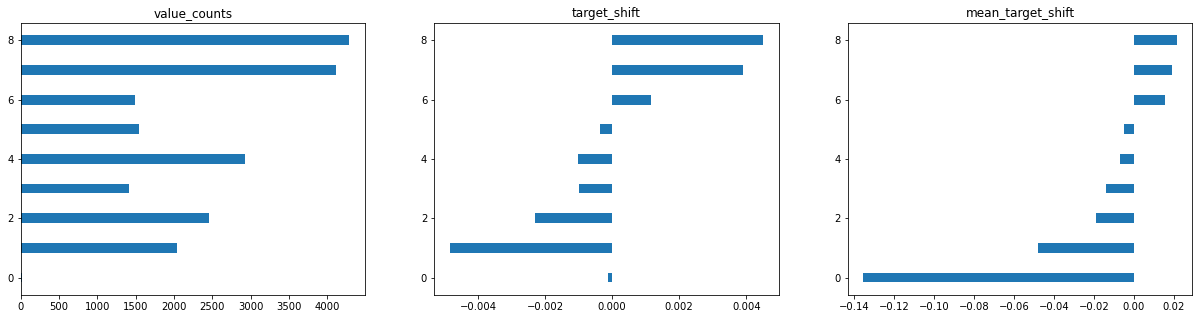

In [127]:
df = order_values (df, bins, 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['КодФакультета_bins0055_ord_cat'], 'Статус_prob')

### Страна_ПП

In [128]:
df['Страна_ПП'] = df['Страна_ПП'].str.lower().str.replace(' ', '_').fillna('isNaN')
df['Страна_ПП'].unique()

array(['россия', 'isNaN', 'казахстан', 'кыргызстан', 'китай',
       'таджикистан', 'казахстан_респ', 'киргизия', 'армения',
       'туркменистан', 'нигерия', 'таджикистан_респ', 'росссия',
       'узбекистан', 'кыргызия', 'франция', 'кыргызская_республика',
       'монголия', 'казахстан_вко', 'республика_казахстан',
       'республика_таджикистан', 'украина', 'афганистан'], dtype=object)

In [129]:
countries_mapping = dict(
    киргизия = 'кыргызстан', 
    кыргызия = 'кыргызстан', 
    кыргызская_республика = 'кыргызстан',
    казахстан_респ = 'казахстан', 
    казахстан_вко = 'казахстан', 
    республика_казахстан = 'казахстан',
    таджикистан_респ = 'таджикистан',
    республика_таджикистан = 'таджикистан'
    )

df.loc[df['Страна_ПП'].isin(countries_mapping.keys()), 'Страна_ПП'] = df.loc[df['Страна_ПП'].isin(countries_mapping.keys()), 'Страна_ПП'].map(countries_mapping)
df.loc[df['Страна_ПП'] == 'росссия', 'Страна_ПП'] = 'россия'
df['Страна_ПП'].unique()

array(['россия', 'isNaN', 'казахстан', 'кыргызстан', 'китай',
       'таджикистан', 'армения', 'туркменистан', 'нигерия', 'узбекистан',
       'франция', 'монголия', 'украина', 'афганистан'], dtype=object)



Страна_ПП : Условная ценность =  nan



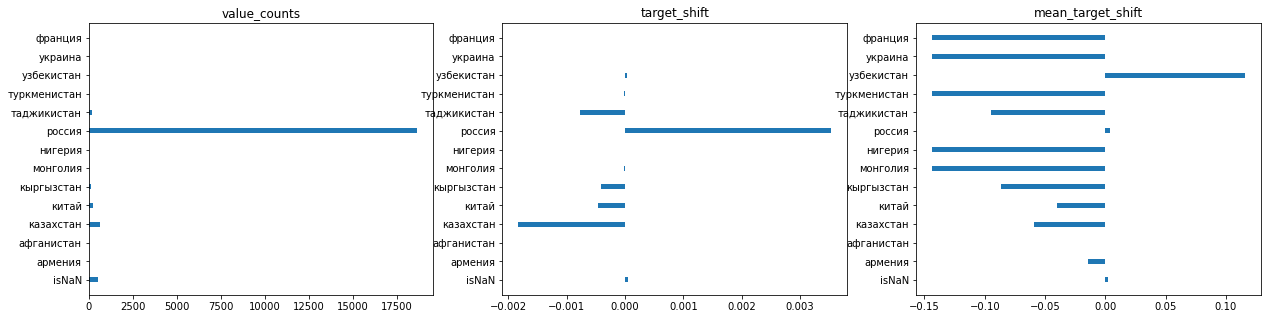

In [130]:
print_barhs_reg_mean(df, ['Страна_ПП'], 'Статус_prob')

In [131]:
df.loc[~df['Страна_ПП'].isin(['россия', 'казахстан', 'китай','кыргызстан','таджикистан']), 'Страна_ПП'] = 'Другое'



Страна_ПП : Условная ценность =  0.001



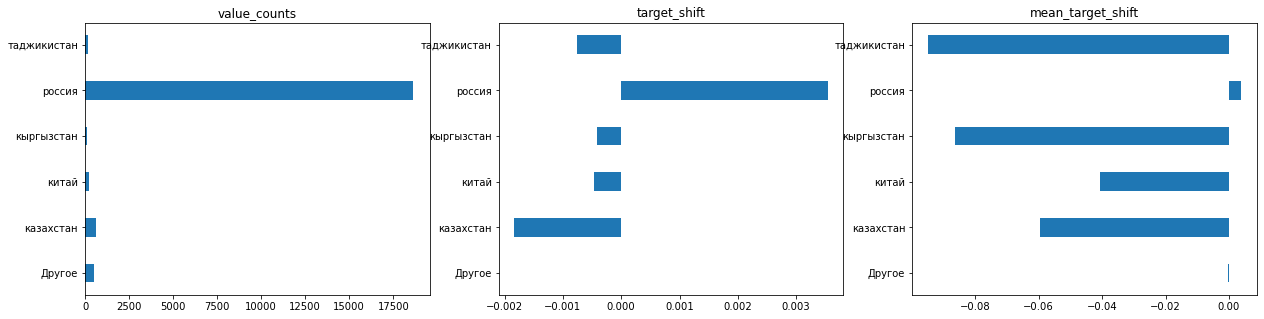

In [132]:
print_barhs_reg_mean(df, ['Страна_ПП'], 'Статус_prob')

In [133]:
df['Страна_ПП_Россия'] = np.where(df['Страна_ПП'] == 'россия', 1, 0)



Страна_ПП_ord_cat : Условная ценность =  0.001



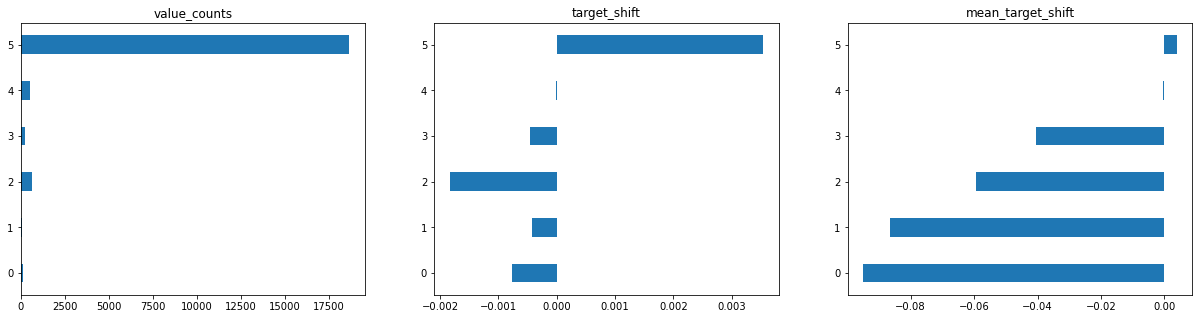

In [134]:
df = order_values (df, ['Страна_ПП'], 'Статус_prob', 'ord_cat') 
print_barhs_reg_mean(df, ['Страна_ПП_ord_cat'], 'Статус_prob')

### Регион_ПП

In [135]:
# df['Регион_ПП'] = pd.concat([train['Регион_ПП'], test['Регион_ПП']]).reset_index(drop = True)
df['Регион_ПП'] = df['Регион_ПП'].str.lower().fillna('isNaN')

for art in [' ', ',', '.', '(',')', '/', '\\', '"','__']:
    df['Регион_ПП'] = df['Регион_ПП'].str.replace(art, '_')

for i in range (3):
    df['Регион_ПП'] = '_' + df['Регион_ПП'] + '_'
    for art in ['_край_', '_кр_',
    '_область', '_обл_',
    '_республика_', '_респ_',
    '_провинция_',  '_пров_',
    '_аобл_', '_ао_',
    '_г_', 
    '_c_', 
    '_с_',  
    '_п_',
    '__',
    ]:
        df['Регион_ПП'] = df['Регион_ПП'].str.replace(art, '_')
    df['Регион_ПП'] = df['Регион_ПП'].str.strip('_')

In [136]:
# eda.plot(df, 'Регион_ПП')

In [137]:
df['Регион_ПП'].value_counts()

алтайский                 17236
isNaN                       908
алтай                       592
восточно-казахстанская      381
кемеровская                 147
                          ...  
уезд_чжунсянь                 1
алтаский                      1
хэйбэй                        1
алтайский_края                1
чуй                           1
Name: Регион_ПП, Length: 143, dtype: int64

In [138]:
dct = {}
i = 0
regions = df['Регион_ПП'].value_counts().sort_values(ascending = False).index
while len(regions) > i:
    # print (len(regions))
    a = process.extract(regions[i], regions, limit = 100)
    a_l = list(map(lambda x: list(x), a))
    keys = np.array(a_l)[np.where(np.array(a_l)[:, 1].astype(float) >= 92), 0][0]
    for x in keys:
        dct[x] = regions[i]
    df.loc[df['Регион_ПП'].isin(keys), 'Регион_ПП'] = df.loc[df['Регион_ПП'].isin(keys), 'Регион_ПП'].map(dct)
    regions = df['Регион_ПП'].value_counts().sort_values(ascending = False).index
    i += 1

In [139]:
df['Регион_ПП'].nunique()

131

In [140]:
region_mapping = dict([
 ('алтайский_крайай', 'алтайский'),
 ('алтай', 'алтайский'),
 ('в-казахстанская', 'восточно-казахстанская'),
 ('вко', 'восточно-казахстанская')])
df.loc[df['Регион_ПП'].isin(region_mapping.keys()), 'Регион_ПП'] = df.loc[df['Регион_ПП'].isin(region_mapping.keys()), 'Регион_ПП'].map(region_mapping)

In [141]:
df['Регион_ПП'].value_counts().value_counts().sort_index()

1        49
2        16
3        13
4        10
5         4
6         5
7         2
8         1
9         3
10        4
11        1
13        1
14        1
16        1
21        1
22        1
23        1
24        1
25        1
30        1
32        1
41        1
46        1
47        1
63        1
107       1
147       1
485       1
908       1
17901     1
Name: Регион_ПП, dtype: int64

In [142]:
df['Регион_ПП'].value_counts()[df['Регион_ПП'].value_counts() > 10].index

Index(['алтайский', 'isNaN', 'восточно-казахстанская', 'кемеровская',
       'новосибирская', 'павлодарская', 'тыва', 'жалал-абадская',
       'красноярский', 'хатлонская', 'хайнань', 'томская', 'хэйлунцзян',
       'алматинская', 'саха_якутия', 'ляонин', 'гуандун', 'ямало-ненецкий',
       'согдийская', 'иркутская'],
      dtype='object')

In [143]:
regions = df['Регион_ПП'].value_counts()[df['Регион_ПП'].value_counts() > 10].index
df.loc[~df['Регион_ПП'].isin(regions), 'Регион_ПП'] = 'isNaN'

In [144]:
df['Регион_ПП'].value_counts()

алтайский                 17901
isNaN                      1207
восточно-казахстанская      485
кемеровская                 147
новосибирская               107
павлодарская                 63
тыва                         47
жалал-абадская               46
красноярский                 41
хатлонская                   32
хайнань                      30
томская                      25
хэйлунцзян                   24
алматинская                  23
саха_якутия                  22
ляонин                       21
гуандун                      16
ямало-ненецкий               14
согдийская                   13
иркутская                    11
Name: Регион_ПП, dtype: int64

In [145]:
# преобразовываем данные, когда регион и страна не совпадают

for region in df['Регион_ПП'].value_counts().index.drop(['алтайский','isNaN']):
    sorted_by_country = df[df['Регион_ПП'] == region]['Страна_ПП'].value_counts(normalize=True)

    if sorted_by_country[0] < 1:
        df.loc[(df['Регион_ПП'] == region) & (df['Страна_ПП'].isin(sorted_by_country.index[1:])), 'Страна_ПП'] = sorted_by_country.index[0]

for region in ['алтайский']:
    sorted_by_country = df[df['Регион_ПП'] == region]['Страна_ПП'].value_counts(normalize=True)

    if sorted_by_country[0] < 1:
        df.loc[(df['Регион_ПП'] == region) & (df['Страна_ПП'].isin(sorted_by_country.index[1:])), 'Регион_ПП'] = 'isNaN'

In [146]:
df['Регион_ПП'].value_counts()

алтайский                 17885
isNaN                      1223
восточно-казахстанская      485
кемеровская                 147
новосибирская               107
павлодарская                 63
тыва                         47
жалал-абадская               46
красноярский                 41
хатлонская                   32
хайнань                      30
томская                      25
хэйлунцзян                   24
алматинская                  23
саха_якутия                  22
ляонин                       21
гуандун                      16
ямало-ненецкий               14
согдийская                   13
иркутская                    11
Name: Регион_ПП, dtype: int64



Регион_ПП_ord_cat_bins005 : Условная ценность =  0.002



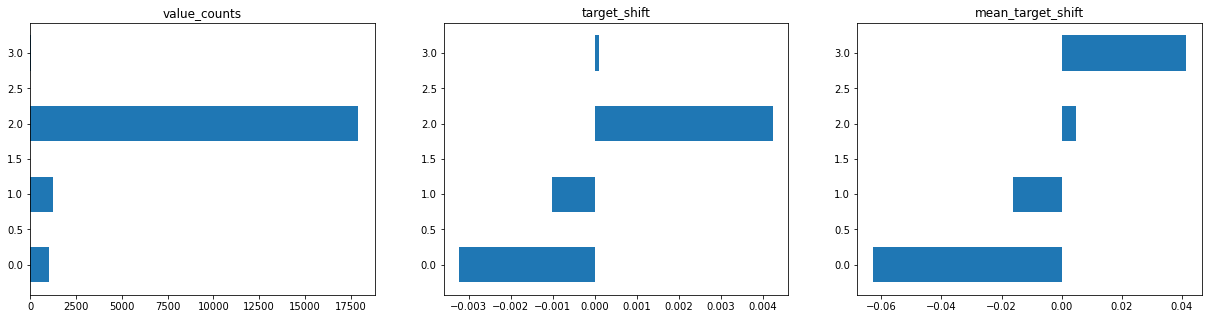

In [147]:
df = order_values(df, ['Регион_ПП'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Регион_ПП_ord_cat'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

россия


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.0



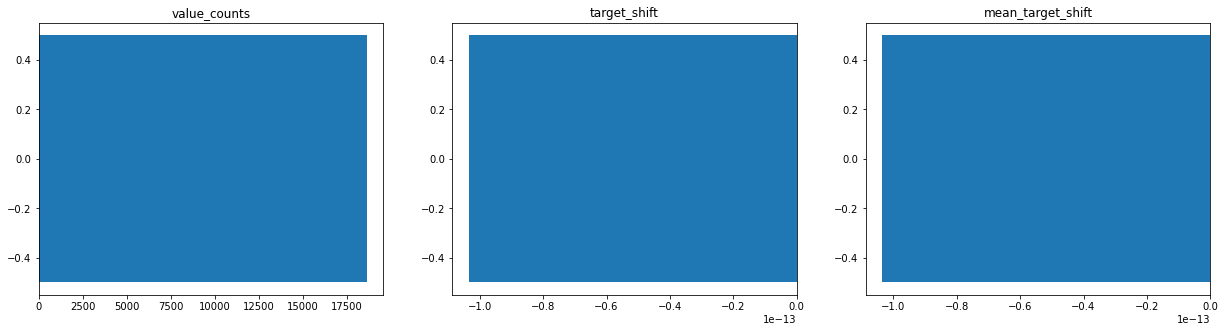


Другое


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.0



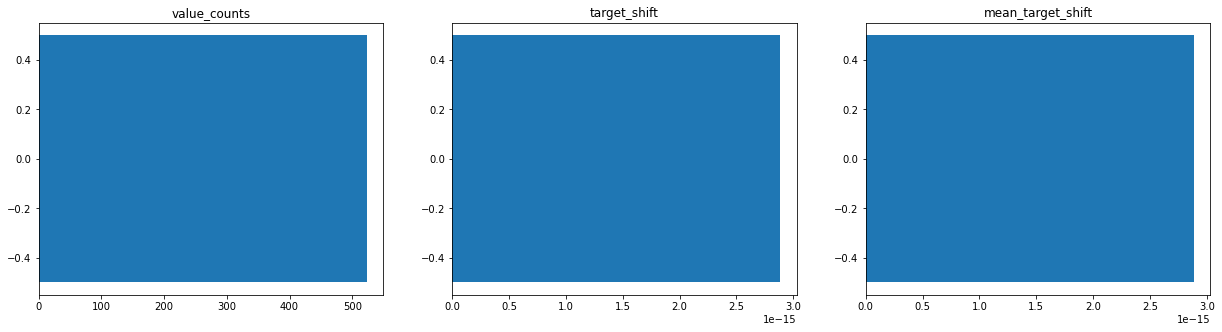


казахстан


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.003



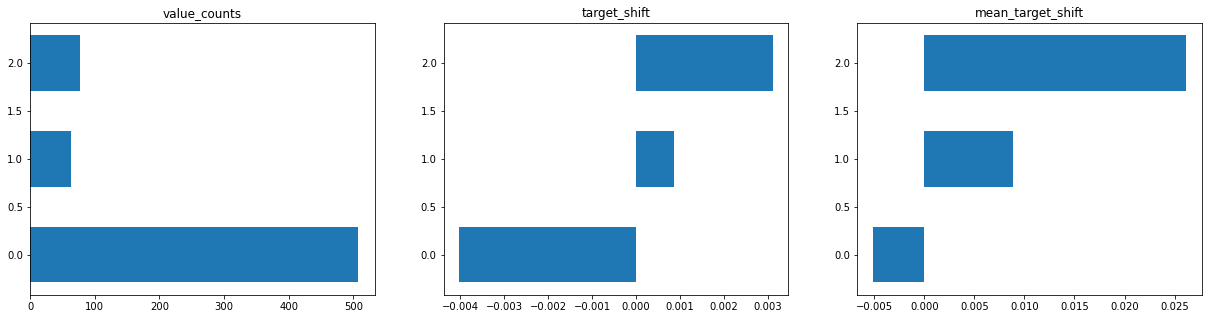


кыргызстан


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.009



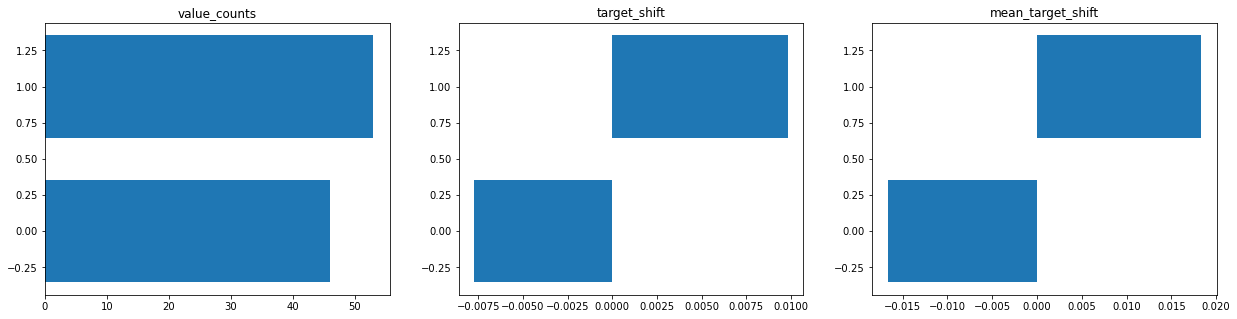


китай


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.008



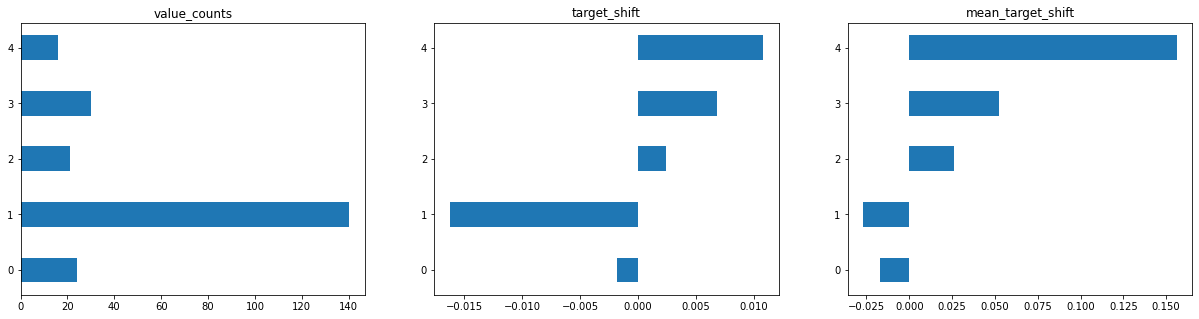


таджикистан


Регион_ПП_ord_cat_bins005 : Условная ценность =  0.002



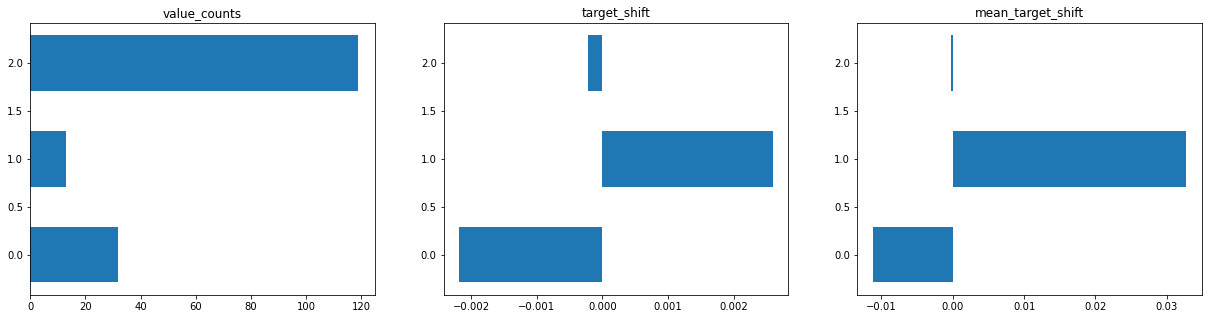

In [148]:
for country in df['Страна_ПП'].unique():
    print (country)
    temp = order_values(df[df['Страна_ПП'] == country], ['Регион_ПП'], 'Статус_prob', 'ord_cat')
    temp, bins = col_by_bins(df[df['Страна_ПП'] == country], ['Регион_ПП_ord_cat'], 0.05)
    # print_barhs_reg_mean(temp[temp['Страна_ПП'] == country], bins, 'Статус_prob')

    df.loc[df['Страна_ПП'] == country, bins] = temp.loc[temp['Страна_ПП'] == country, bins]

### Город_ПП

In [149]:
# df['Город_ПП'] = pd.concat([train['Город_ПП'], test['Город_ПП']]).reset_index(drop = True)

df['Город_ПП'] = df['Город_ПП'].str.lower().fillna('isNaN')

for art in [' ', ',', '.', '(',')', '/', '\\', '"','__']:
    df['Город_ПП'] = df['Город_ПП'].str.replace(art, '_')

for i in range (3):
    df['Город_ПП'] = '_' + df['Город_ПП'] + '_'
    for art in ['_край_', '_кр_',
    '_область', '_обл_',
    '_республика_', '_респ_',
    '_провинция_',  '_пров_',
    '_аобл_', '_ао_',
    '_г_', 
    '_c_', 
    '_с_',  
    '_п_',
    '_россия_', '_рф_', '_китай_', '_кнр_', 
    '_казахстан_', '_вко_', '_восточно-казахстанская_',
    '_кыргызстан_', '_таджикистан_',
    '№','1', '2', '3', '4', '5', '6', '7','8','9','0',
    '__',
    ]:
        df['Город_ПП'] = df['Город_ПП'].str.replace(art, '_')
    df['Город_ПП'] = df['Город_ПП'].str.strip('_')

In [150]:
df['Город_ПП'].value_counts().head(10)

барнаул          10092
бийск              802
isNaN              657
новоалтайск        589
рубцовск           294
камень-на-оби      280
заринск            191
славгород          188
горно-алтайск      166
семей              126
Name: Город_ПП, dtype: int64

In [151]:
dct = {}
i = 0
regions = df['Город_ПП'].value_counts().sort_values(ascending = False).index
while len(regions) > i:
    # print (len(regions))
    a = process.extract(regions[i], regions, limit = 100)
    a_l = list(map(lambda x: list(x), a))
    keys = np.array(a_l)[np.where(np.array(a_l)[:, 1].astype(float) >= 92), 0][0]
    for x in keys:
        dct[x] = regions[i]
    df.loc[df['Город_ПП'].isin(keys), 'Город_ПП'] = df.loc[df['Город_ПП'].isin(keys), 'Город_ПП'].map(dct)
    regions = df['Город_ПП'].value_counts().sort_values(ascending = False).index
    i += 1

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '-']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '-']


In [152]:
df['Город_ПП'].value_counts().head(10)

барнаул          10094
бийск              802
isNaN              657
новоалтайск        595
рубцовск           294
камень-на-оби      282
заринск            191
славгород          188
горно-алтайск      167
семей              126
Name: Город_ПП, dtype: int64

In [153]:
df['Город_ПП'].value_counts().value_counts().sort_index().head(20)

1     729
2     219
3     126
4      70
5      54
6      37
7      31
8      25
9      19
10     10
11      7
12      8
13      8
14      4
15      5
16     11
17      7
18      2
20      6
21      6
Name: Город_ПП, dtype: int64

In [154]:
df['Город_ПП'].value_counts()[df['Город_ПП'].value_counts() > 16].index

Index(['барнаул', 'бийск', 'isNaN', 'новоалтайск', 'рубцовск', 'камень-на-оби',
       'заринск', 'славгород', 'горно-алтайск', 'семей', 'белокуриха',
       'усть-каменогорск', 'алейск', 'павловск', 'зато_сибирский', 'яровое',
       'риддер', 'тальменка_рп', 'алтайское', '', 'шемонаиха', 'волчиха',
       'троицкое', 'горняк', 'душанбе', 'шипуново', 'новосибирск', 'павлодар',
       'поспелиха', 'ребриха', 'кулунда', 'кош-агач', 'ключи', 'первомайское',
       'берёзовка', 'залесово', 'майма', 'михайловское', 'мамонтово',
       'благовещенка_рп', 'родино', 'топчиха', 'боровиха', 'новокузнецк',
       'староалейское', 'бобровка', 'змеиногорск', 'смоленское', 'тюменцево',
       'красногорское', 'советское', 'барнаул_власиха', 'целинное',
       'степное_озеро_рп', 'зудилово', 'санниково', 'новичиха',
       'барнаул_южный', 'шебалино', 'шелаболиха', 'усть-калманка', 'романово',
       'калманка', 'завьялово', 'табуны', 'маралиха', 'краснощёково',
       'онгудай', 'петропавловское', 

In [155]:
cities = df['Город_ПП'].value_counts()[df['Город_ПП'].value_counts() > 16].index

In [156]:
df.loc[~df['Город_ПП'].isin(cities), 'Город_ПП'] = 'isNaN'

In [157]:
df['Город_ПП'].value_counts()

барнаул                    10094
isNaN                       4246
бийск                        802
новоалтайск                  595
рубцовск                     294
                           ...  
усть-чарышская_пристань       17
красный_яр                    17
панкрушиха                    17
косиха                        17
усть-кан                      17
Name: Город_ПП, Length: 97, dtype: int64

In [158]:
for region in df['Город_ПП'].value_counts().index.drop(['isNaN']):
    # print (region)
    sorted_by_country = df[(df['Город_ПП'] == region) & (df['Регион_ПП'] != 'isNaN')]['Регион_ПП'].value_counts(normalize=True)
    # print (sorted_by_country)
    print ()

    if sorted_by_country[0] < 1:
        # display(df.loc[(df['Город_ПП'] == region) & (df['Регион_ПП'].isin(sorted_by_country.index[1:])), :'Общежитие'])
        df.loc[(df['Город_ПП'] == region) & (df['Регион_ПП'].isin(sorted_by_country.index[1:])), 'Регион_ПП'] = 'isNaN'



Город_ПП_ord_cat_bins005 : Условная ценность =  0.002



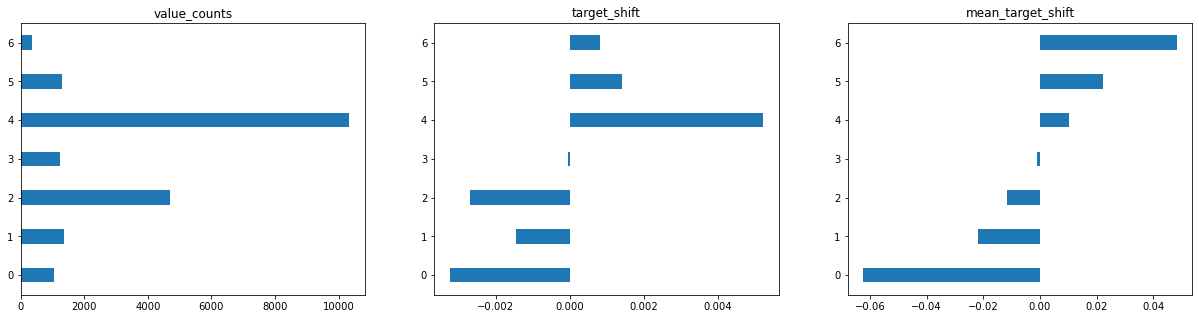

In [159]:
df = order_values(df, ['Город_ПП'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Город_ПП_ord_cat'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

алтайский


Город_ПП_ord_cat_bins005 : Условная ценность =  0.001



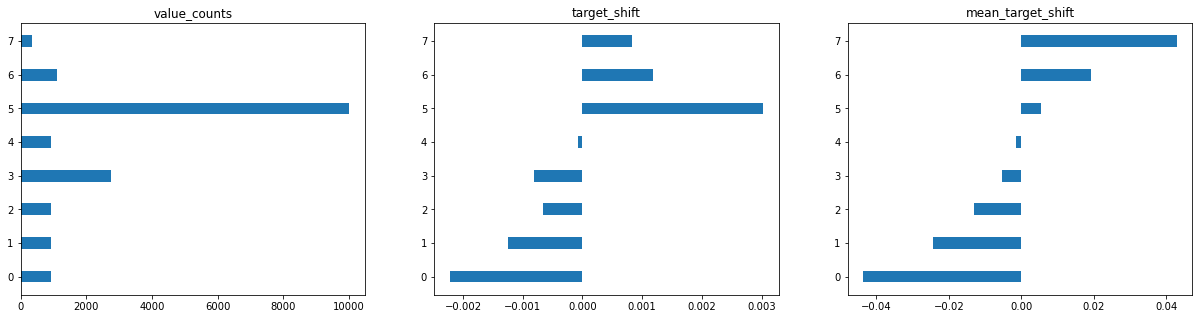


isNaN


Город_ПП_ord_cat_bins005 : Условная ценность =  0.003



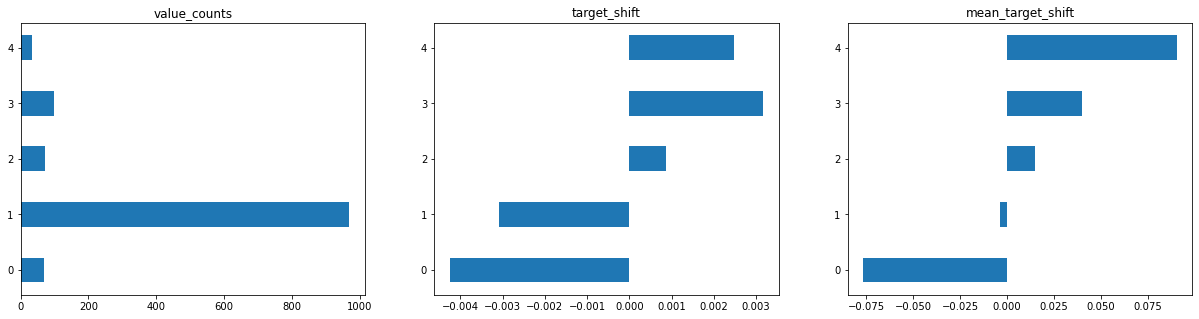


восточно-казахстанская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.005



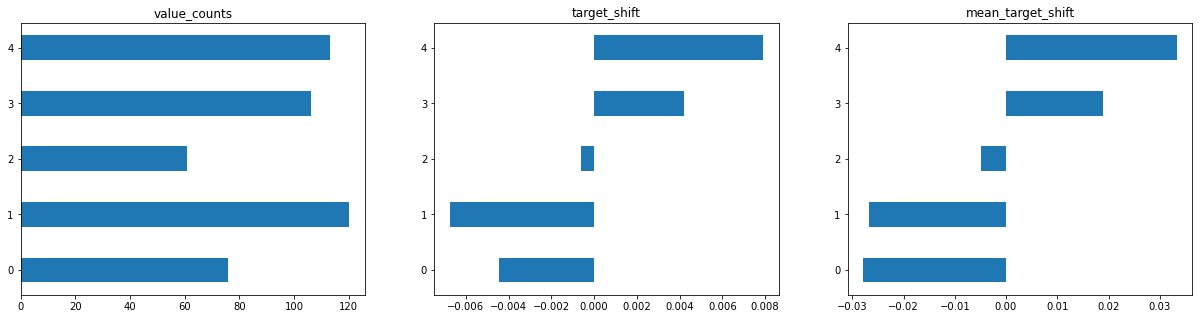


жалал-абадская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.029



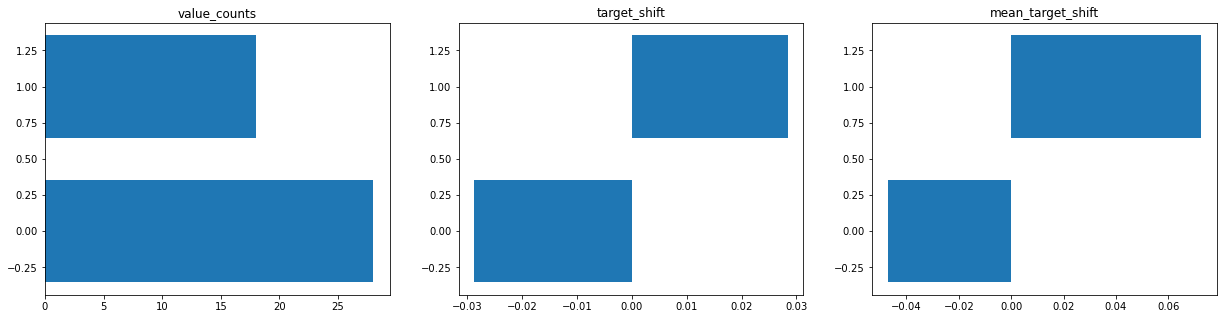


павлодарская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.014



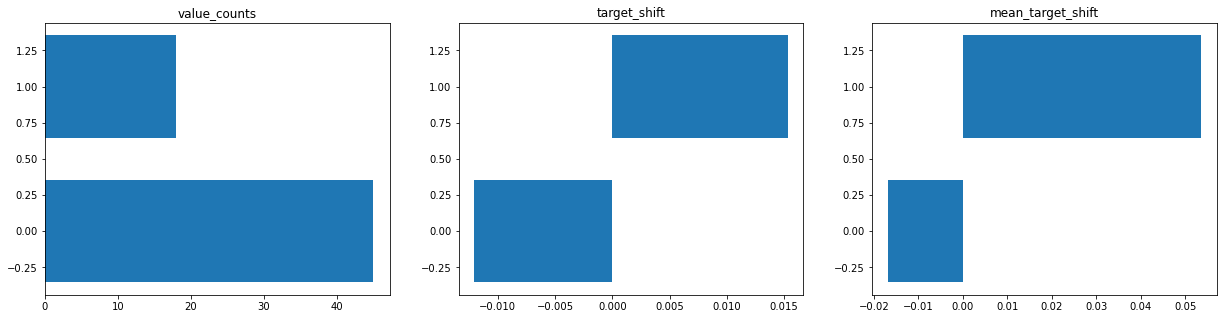


гуандун


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



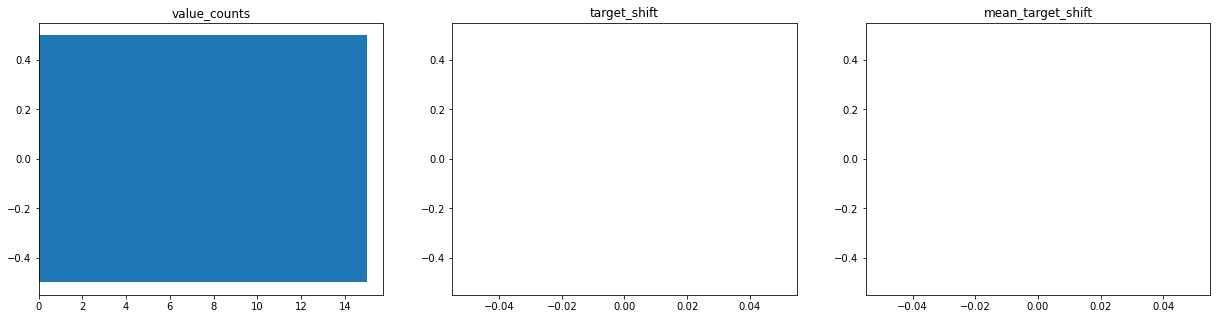


ляонин


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



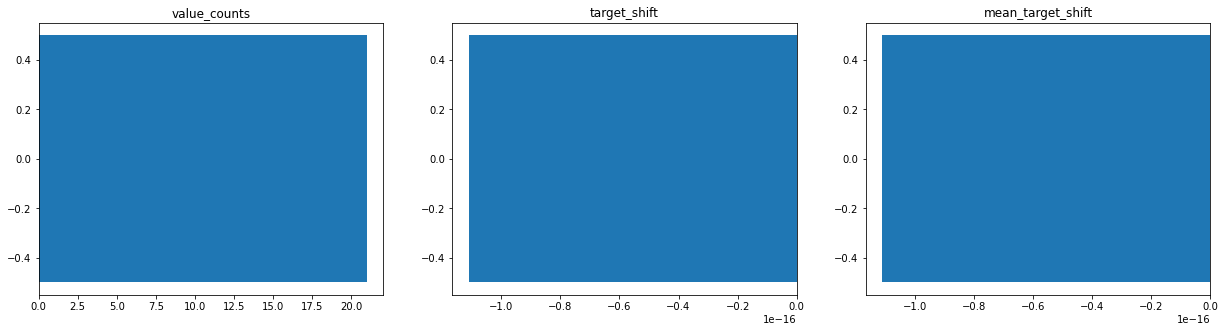


хатлонская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.005



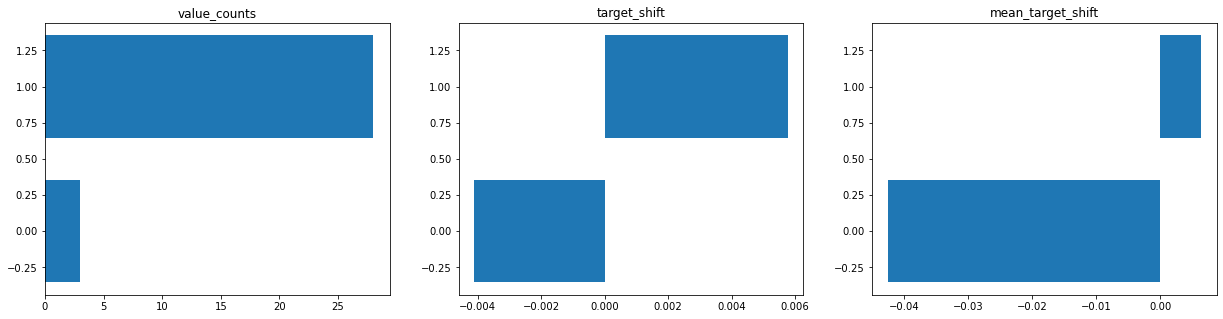


алматинская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



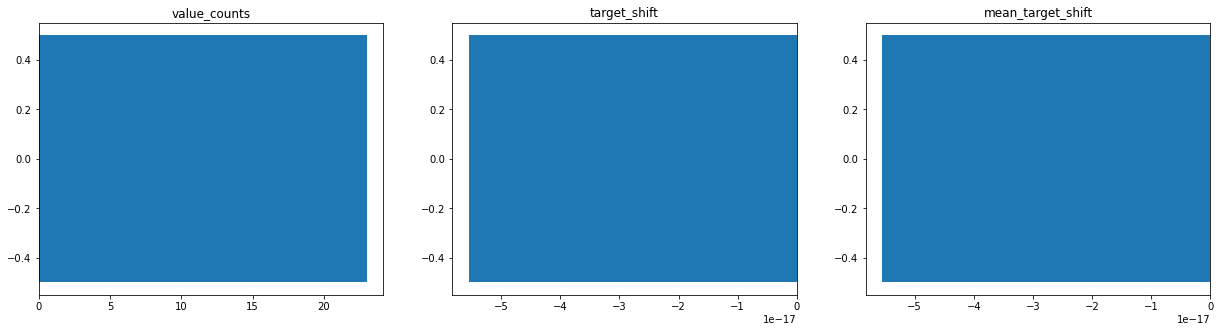


кемеровская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.003



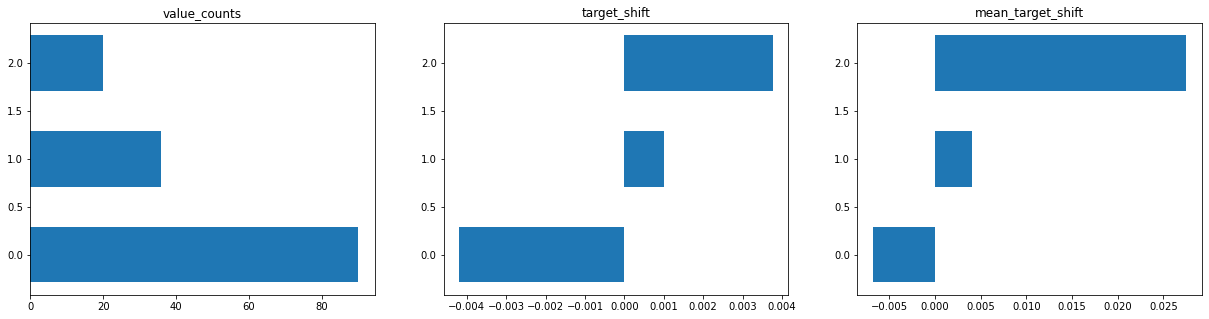


новосибирская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.012



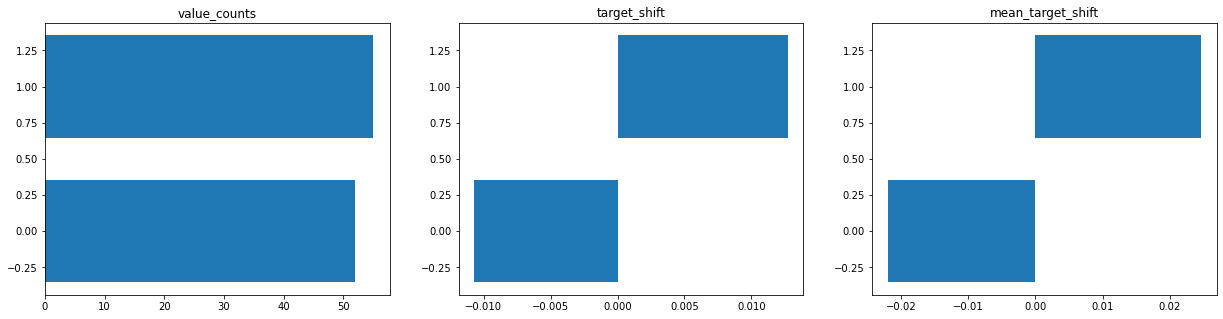


тыва


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



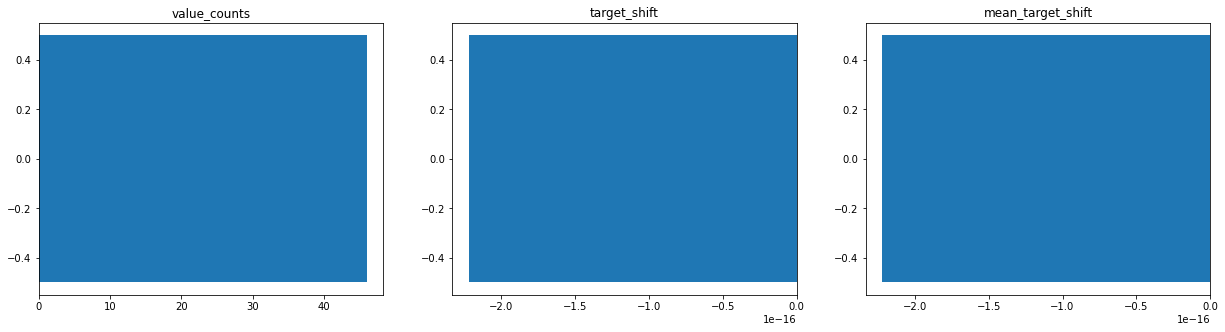


хайнань


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



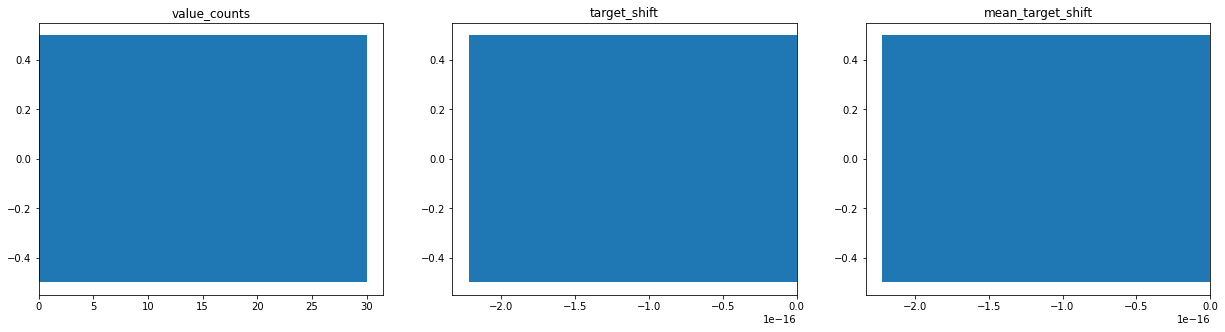


саха_якутия


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



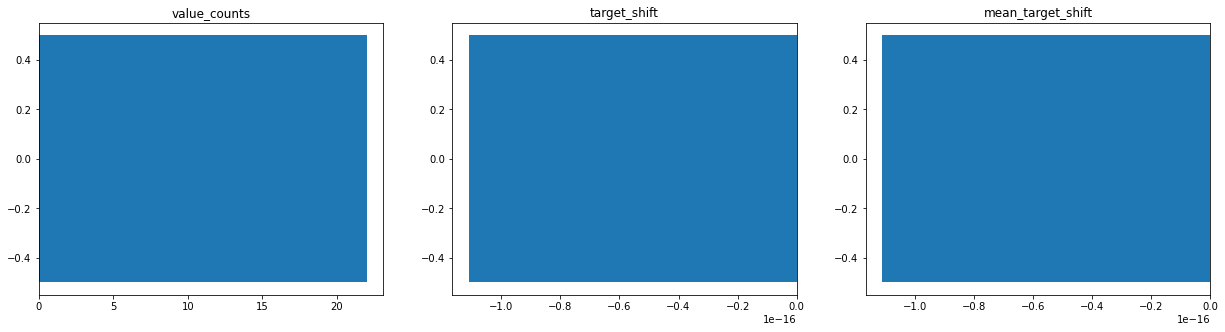


хэйлунцзян


Город_ПП_ord_cat_bins005 : Условная ценность =  0.01



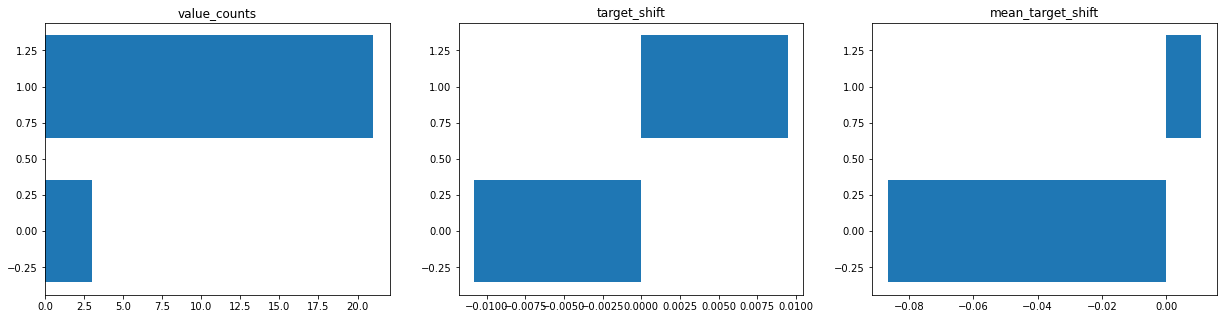


томская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



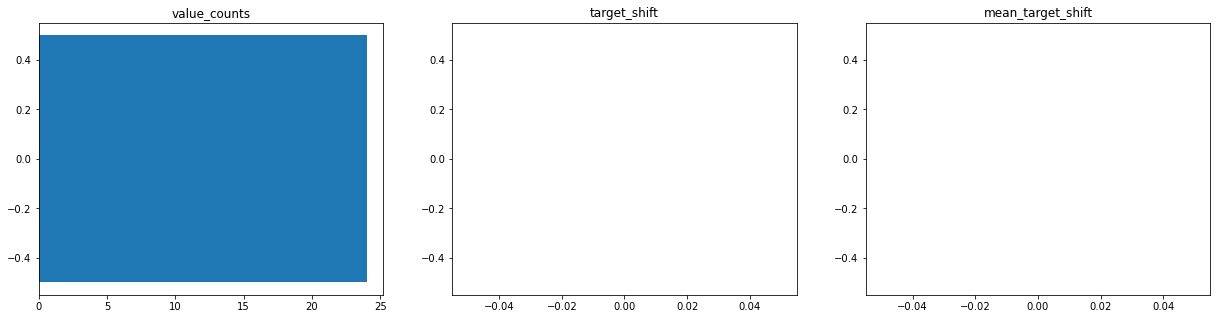


красноярский


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



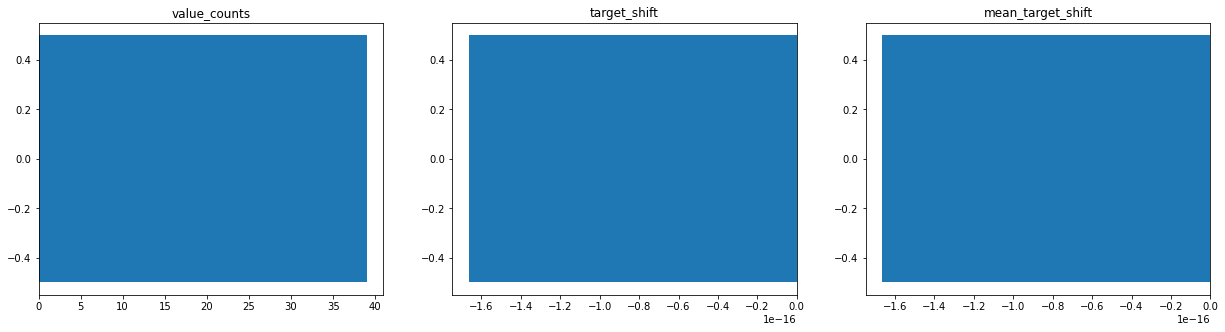


ямало-ненецкий


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



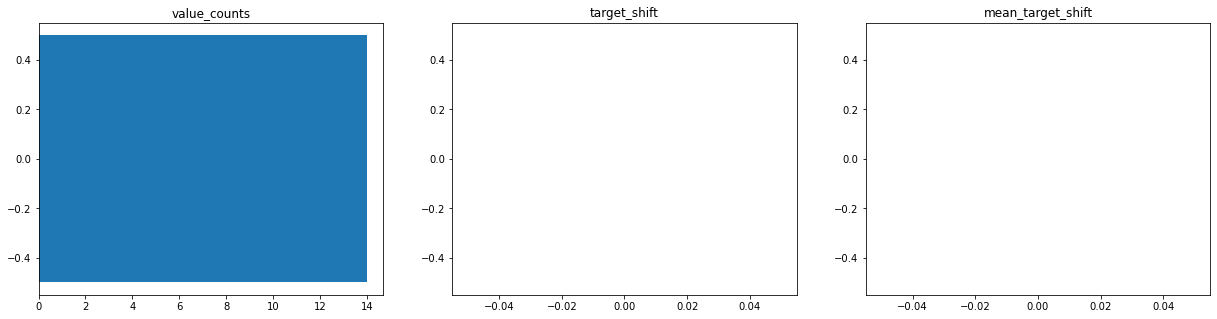


иркутская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



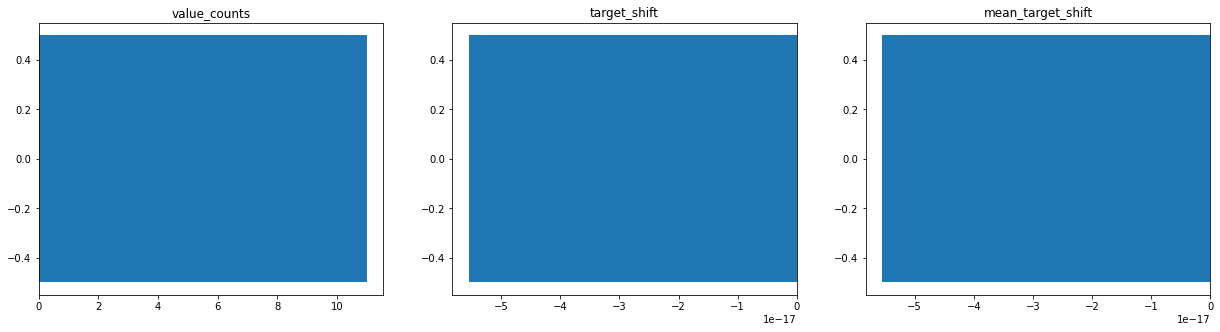


согдийская


Город_ПП_ord_cat_bins005 : Условная ценность =  0.0



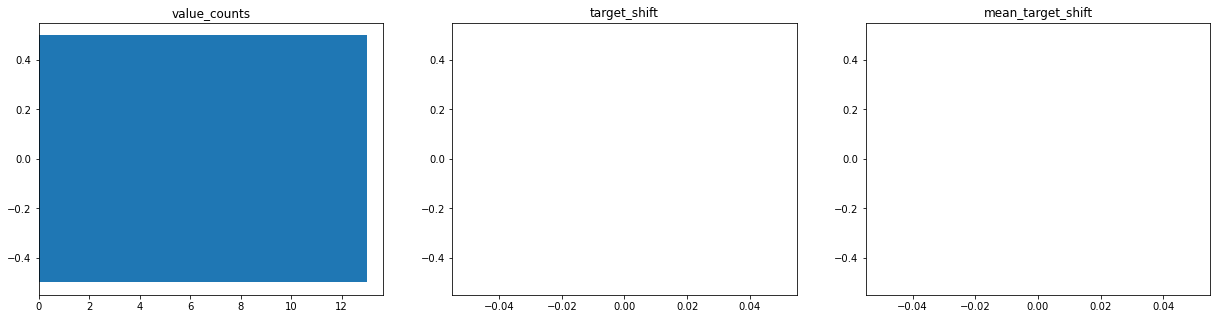

In [160]:
for country in df['Регион_ПП'].unique():
    print(country)
    temp = order_values(df[df['Регион_ПП'] == country], ['Город_ПП'], 'Статус_prob', 'ord_cat')
    temp, bins = col_by_bins(temp[temp['Регион_ПП'] == country], ['Город_ПП_ord_cat'], 0.05)
    # print_barhs_reg_mean(temp[temp['Регион_ПП'] == country], bins, 'Статус_prob')
    df.loc[df['Регион_ПП'] == country, bins] = temp.loc[temp['Город_ПП'] == country, bins]

### Где_Находится_УЗ

In [161]:
# df['Где_Находится_УЗ'] = pd.concat([train['Где_Находится_УЗ'], test['Где_Находится_УЗ']]).reset_index(drop = True)
df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].str.lower().fillna('isNaN')

for art in [' ', ',', '.', '(',')', '/', '\\', '"','__']:
    df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].str.replace(art, '_')

for i in range (3):
    df['Где_Находится_УЗ'] = '_' + df['Где_Находится_УЗ'] + '_'
    for art in ['_край_', '_кр_',
    '_область', '_обл_',
    '_республика_', '_респ_',
    '_провинция_',  '_пров_',
    '_аобл_', '_ао_',
    '_г_', '_город_',
    '_c_', '_село_',
    '_с_',  
    '_п_',
    '_россия_', '_рф_', '_китай_', '_кнр_', 
    '_казахстан_', '_вко_', '_восточно-казахстанская_',
    '_кыргызстан_', '_таджикистан_', 
    '_алтайский_',
    '__',
    ]:
        df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].str.replace(art, '_')
    df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].str.strip('_')

In [162]:
df['Где_Находится_УЗ'].value_counts()

барнаул                        9895
isNaN                          2041
бийск                           728
новоалтайск                     279
алтай_горно-алтайск             266
                               ... 
гунчжулин                         1
глубоковский_р-н_глубокое         1
троицкий_р-н_зеленая_поляна       1
крутихинский_р-н_подборный        1
тюменцевский_р-н_карповский       1
Name: Где_Находится_УЗ, Length: 1890, dtype: int64

In [163]:
dct = {}
i = 0
regions = df['Где_Находится_УЗ'].value_counts().sort_values(ascending = False).index
while len(regions) > i:
    # print (len(regions))
    a = process.extract(regions[i], regions, limit = 100)
    a_l = list(map(lambda x: list(x), a))
    keys = np.array(a_l)[np.where(np.array(a_l)[:, 1].astype(float) >= 90), 0][0]
    for x in keys:
        dct[x] = regions[i]
    df.loc[df['Где_Находится_УЗ'].isin(keys), 'Где_Находится_УЗ'] = df.loc[df['Где_Находится_УЗ'].isin(keys), 'Где_Находится_УЗ'].map(dct)
    regions = df['Где_Находится_УЗ'].value_counts().sort_values(ascending = False).index
    i += 1

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


In [164]:
df['Где_Находится_УЗ'].value_counts()

барнаул                                                           10179
isNaN                                                              2041
бийск                                                               855
новоалтайск                                                         314
алтай_горно-алтайск                                                 272
                                                                  ...  
согдийская_пенджекент                                                 1
муниципальный_р-он_верхнеколымский_улус_район_р-ка_саха_якутия        1
боровое_крутихинсконо_р-на                                            1
журавлиха                                                             1
баевский_р-н_верх-чуманка                                             1
Name: Где_Находится_УЗ, Length: 1158, dtype: int64

In [165]:
df['Где_Находится_УЗ'].value_counts().value_counts().sort_index().head(20)

1     639
2     181
3      91
4      44
5      32
6      10
7      23
8      17
9       6
10      8
11      6
12      5
13      3
14      1
15      7
16      6
17      5
18      5
19      1
20      6
Name: Где_Находится_УЗ, dtype: int64

In [166]:
df['Где_Находится_УЗ'].value_counts()[df['Где_Находится_УЗ'].value_counts() > 8].index

Index(['барнаул', 'isNaN', 'бийск', 'новоалтайск', 'алтай_горно-алтайск',
       'москва', 'рубцовск', 'заринск', 'камень-на-оби', 'славгород',
       ...
       'крутихинский_р-н_крутиха', 'благовещенский_р-н_леньки',
       'новичихинский_район_алтайского_края', 'бородулинский_р-н_жезкент',
       'семипалатинск', 'тальменский_район', 'алтай_шебалинский_р-н_шебалино',
       'калманский_р-н_новороманово', 'родинский_район_алтайского_края',
       'зональный_р-н_буланиха'],
      dtype='object', length=121)

In [167]:
cities = df['Где_Находится_УЗ'].value_counts()[df['Где_Находится_УЗ'].value_counts() > 8].index

In [168]:
df.loc[~df['Где_Находится_УЗ'].isin(cities), 'Где_Находится_УЗ'] = 'isNaN'

In [169]:
df['Где_Находится_УЗ'].value_counts().head(20)

барнаул                      10179
isNaN                         4008
бийск                          855
новоалтайск                    314
алтай_горно-алтайск            272
москва                         261
рубцовск                       221
заринск                        204
камень-на-оби                  193
славгород                      182
семей                          147
усть-каменогорск               135
новосибирская_новосибирск      132
алейск                         127
риддер                         108
первомайский_р-н               107
шемонаиха                       96
душанбе                         94
павлодар                        93
                                83
Name: Где_Находится_УЗ, dtype: int64

In [170]:
# mapping = dict(
# барнаул_алтайского_края = 'барнаул',
# бийск_ак = 'бийск',
# барнаул_алтайского_края = 'барнаул',
# )

# df.loc[df['Где_Находится_УЗ'].isin(mapping.keys()), 'Где_Находится_УЗ'] = df.loc[df['Где_Находится_УЗ'].isin(mapping.keys()), 'Где_Находится_УЗ'].map(mapping)

In [171]:
df = order_values(df, ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Где_Находится_УЗ_ord_cat'], 0.01)
# print_barhs_reg_mean(df, bins, 'Статус_prob')

In [172]:
df = order_values(df, ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Где_Находится_УЗ_ord_cat'], 0.025)
# print_barhs_reg_mean(df, bins, 'Статус_prob')



Где_Находится_УЗ_ord_cat_bins005 : Условная ценность =  0.002



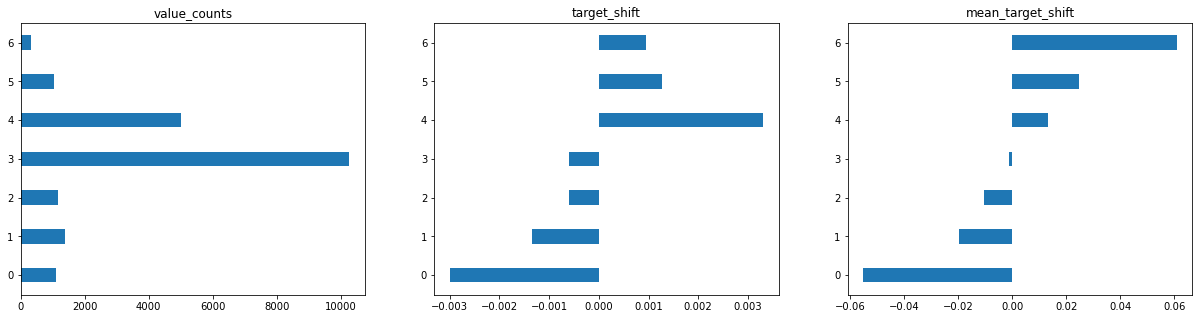

In [173]:
df = order_values(df, ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Где_Находится_УЗ_ord_cat'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [ ]:
for country in df['Город_ПП'].unique():
    print(country)
    temp = order_values(df[df['Город_ПП'] == country], ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat')
    temp, bins = col_by_bins(temp[temp['Город_ПП'] == country], ['Где_Находится_УЗ_ord_cat'], 0.05)
    # print_barhs_reg_mean(temp[temp['Город_ПП'] == country], bins, 'Статус_prob')

    df.loc[df['Город_ПП'] == country, bins] = temp.loc[temp['Где_Находится_УЗ'] == country, bins]

### Уч_Заведение

In [175]:
# df['Уч_Заведение'] = pd.concat([train['Уч_Заведение'], test['Уч_Заведение']]).reset_index(drop = True)

df['Уч_Заведение'] = df['Уч_Заведение'].str.lower().fillna('isNaN')

for art in [' ', ',', '.', '(',')', '/', '\\', '"','__']:
    df['Уч_Заведение'] = df['Уч_Заведение'].str.replace(art, '_')

for i in range (3):
    df['Уч_Заведение'] = '_' + df['Уч_Заведение'] + '_'
    for art in ['_край_', '_кр_',
    '_область', '_обл_',
    '_республика_', '_респ_',
    '_провинция_',  '_пров_',
    '_аобл_', '_ао_',
    '_г_', 
    '_c_', 
    '_с_',  
    '_п_',
    '_россия_', '_рф_', '_китай_', '_кнр_', 
    '_казахстан_', '_вко_', '_восточно-казахстанская_',
    '_кыргызстан_', '_таджикистан_',
    '№','1', '2', '3', '4', '5', '6', '7','8','9','0',
    '__',
    ]:
        df['Уч_Заведение'] = df['Уч_Заведение'].str.replace(art, '_')
    df['Уч_Заведение'] = df['Уч_Заведение'].str.strip('_')


In [176]:
df['универ'] = 0
df['колледж'] = 0
df['сош'] = 0
df['гимназ'] = 0
df['лице'] = 0
df['среднее_образование'] = 0

cols2 = ['универ', 'колледж', 'сош', 'гимназ', 'лице']

for col in df['Уч_Заведение'].unique():
    # print (col)
    for col2 in ['универ', 'колледж', 'сош', 'гимназ', 'лице']:
        if col2 in col:
            df.loc[df['Уч_Заведение'] == col, col2] = 1

    if (cols2[2] in col) or (cols2[3] in col) or (cols2[4] in col):
        df.loc[df['Уч_Заведение'] == col, 'среднее_образование'] = 1

In [177]:
# eda.plot(df, 'Уч_Заведение')

In [178]:
df['Уч_Заведение'].value_counts().head(20)

фгбоу_во_алтайский_государственный_университет                                  2041
мбоу_сош                                                                        1880
isNaN                                                                           1811
фгбоу_впо_алтайский_государственный_университет                                 1757
мбоу_гимназия                                                                   1101
мбоу_лицей                                                                       832
мбоу_сош_углубленным_изучением_отдельных_предметов                               325
фгбоу_впо_алтайский_государственный_технический_университет_им_и_и_ползунова     183
фгбоу_во_алтайский_государственный_технический_университет_им_и_и_ползунова      160
гоу_впо_алтайский_государственный_университет                                    130
алтайский_государственный_университет                                            121
мбоу_гимназия_им_героя_советского_союза_в_е_смирнова             

In [179]:
dct = {}
i = 0
regions = df['Уч_Заведение'].value_counts().sort_values(ascending = False).index
while len(regions) > i:
    # print (len(regions))
    a = process.extract(regions[i], regions, limit = 100)
    a_l = list(map(lambda x: list(x), a))
    keys = np.array(a_l)[np.where(np.array(a_l)[:, 1].astype(float) >= 90), 0][0]
    for x in keys:
        dct[x] = regions[i]
    df.loc[df['Уч_Заведение'].isin(keys), 'Уч_Заведение'] = df.loc[df['Уч_Заведение'].isin(keys), 'Уч_Заведение'].map(dct)
    regions = df['Уч_Заведение'].value_counts().sort_values(ascending = False).index
    i += 1

In [180]:
df['Уч_Заведение'].value_counts()

фгбоу_во_алтайский_государственный_университет          4278
мбоу_сош_им_героя_советского_союза_а_спекова            2786
isNaN                                                   1811
мбоу_гимназия                                           1433
мбоу_лицей                                              1250
                                                        ... 
мкоу_каяушенская_сош                                       1
гоу_спо_новосибирский_техникум_легкой_промышленности       1
средняя_школа_уезда_умин_городского_округа_наньнин         1
моу_бурановская_сош                                        1
назарбаев_интеллектуальная_школа                           1
Name: Уч_Заведение, Length: 1880, dtype: int64

In [181]:
df['Уч_Заведение'].value_counts().value_counts().sort_index().head(25)

1     1086
2      248
3      114
4       80
5       61
6       40
7       36
8       18
9       19
10       9
11      14
12      12
13      10
14       1
15       8
16      10
17       8
18       7
19      10
20       4
21       6
22       5
23       1
24       6
25       3
Name: Уч_Заведение, dtype: int64

In [182]:
cities = df['Уч_Заведение'].value_counts()[df['Уч_Заведение'].value_counts() > 19].index
df.loc[~df['Уч_Заведение'].isin(cities), 'Уч_Заведение'] = 'isNaN'
df['Уч_Заведение'].value_counts().head(20)

isNaN                                                                                                            6431
фгбоу_во_алтайский_государственный_университет                                                                   4278
мбоу_сош_им_героя_советского_союза_а_спекова                                                                     2786
мбоу_гимназия                                                                                                    1433
мбоу_лицей                                                                                                       1250
фгбоу_впо_алтайский_государственный_технический_университет_им_и_и_ползунова                                      468
кгу_сош                                                                                                           158
алтайский_государственный_университет                                                                             136
кгбоу_спо_барнаульский_государственный_педагогический_ко

In [183]:
mapping = dict(
алтайский_государственный_университет = 'фгбоу_во_алтайский_государственный_университет',
)

df.loc[df['Уч_Заведение'].isin(mapping.keys()), 'Уч_Заведение'] = df.loc[df['Уч_Заведение'].isin(mapping.keys()), 'Уч_Заведение'].map(mapping)



Уч_Заведение_ord_cat_bins005 : Условная ценность =  0.001



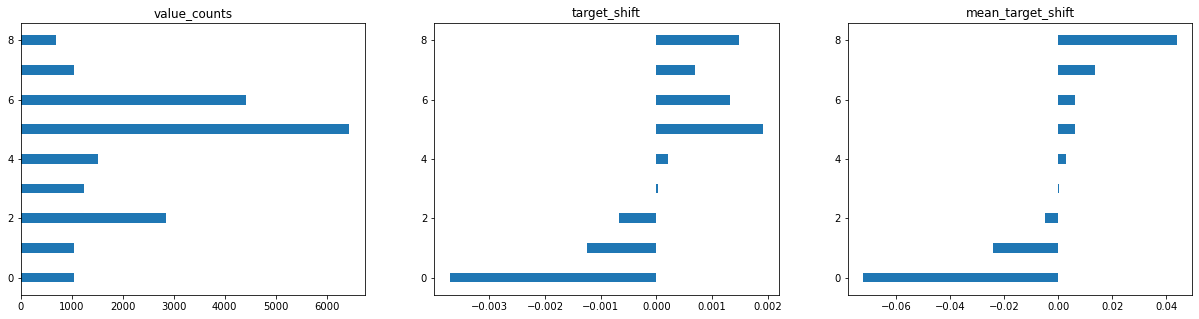

In [184]:
df = order_values(df, ['Уч_Заведение'], 'Статус_prob', 'ord_cat')
df, bins = col_by_bins(df, ['Уч_Заведение_ord_cat'], 0.05)
print_barhs_reg_mean(df, bins, 'Статус_prob')

In [ ]:
for country in df['Где_Находится_УЗ'].unique():
    temp = order_values(df[df['Где_Находится_УЗ'] == country], ['Уч_Заведение'], 'Статус_prob', 'ord_cat')
    temp, bins = col_by_bins(temp[temp['Где_Находится_УЗ'] == country], ['Уч_Заведение_ord_cat'], 0.05)
    # print_barhs_reg_mean(temp[temp['Где_Находится_УЗ'] == country], bins, 'Статус_prob')

    df.loc[df['Где_Находится_УЗ'] == country, bins] = temp.loc[temp['Уч_Заведение'] == country, bins]

## Дополнительные фичи

In [186]:
# доля уникального значения в более общем уникальном значении другого признака

for country in df['Страна_ПП'].unique():
    
    mapping = df[df['Страна_ПП'] == country]['Регион_ПП'].value_counts(normalize=True)
    df.loc[df['Страна_ПП'] == country, 'Страна_Регион_vc'] = df[df['Страна_ПП'] == country]['Регион_ПП'].map(mapping)

    mapping = df[df['Страна_ПП'] == country]['Город_ПП'].value_counts(normalize=True)
    df.loc[df['Страна_ПП'] == country, 'Страна_Город_vc'] = df[df['Страна_ПП'] == country]['Город_ПП'].map(mapping)

    mapping = df[df['Страна_ПП'] == country]['Где_Находится_УЗ'].value_counts(normalize=True)
    df.loc[df['Страна_ПП'] == country, 'Страна_Где_Находится_УЗ_vc'] = df[df['Страна_ПП'] == country]['Где_Находится_УЗ'].map(mapping)   

    mapping = df[df['Страна_ПП'] == country]['Уч_Заведение'].value_counts(normalize=True)
    df.loc[df['Страна_ПП'] == country, 'Страна_Уч_Заведение_vc'] = df[df['Страна_ПП'] == country]['Уч_Заведение'].map(mapping)
 
for country in df['Регион_ПП'].unique():

    mapping = df[df['Регион_ПП'] == country]['Город_ПП'].value_counts(normalize=True)
    df.loc[df['Регион_ПП'] == country, 'Регион_Город_vc'] = df[df['Регион_ПП'] == country]['Город_ПП'].map(mapping)

    mapping = df[df['Регион_ПП'] == country]['Где_Находится_УЗ'].value_counts(normalize=True)
    df.loc[df['Регион_ПП'] == country, 'Регион_Где_Находится_УЗ_vc'] = df[df['Регион_ПП'] == country]['Где_Находится_УЗ'].map(mapping)   

    mapping = df[df['Регион_ПП'] == country]['Уч_Заведение'].value_counts(normalize=True)
    df.loc[df['Регион_ПП'] == country, 'Регион_Уч_Заведение_vc'] = df[df['Регион_ПП'] == country]['Уч_Заведение'].map(mapping)

for country in df['Город_ПП'].unique():

    mapping = df[df['Город_ПП'] == country]['Уч_Заведение'].value_counts(normalize=True)
    df.loc[df['Город_ПП'] == country, 'Город_Уч_Заведение_vc'] = df[df['Город_ПП'] == country]['Уч_Заведение'].map(mapping)    

for country in df['Где_Находится_УЗ'].unique():

    mapping = df[df['Где_Находится_УЗ'] == country]['Уч_Заведение'].value_counts(normalize=True)
    df.loc[df['Где_Находится_УЗ'] == country, 'Где_Находится_Уч_Заведение_vc'] = df[df['Где_Находится_УЗ'] == country]['Уч_Заведение'].map(mapping)    

In [187]:
# важность уникальныого значения в более общем уникальном значении другого признака

for country in df['Регион_ПП'].unique():
    
    temp = order_values(df[df['Регион_ПП'] == country], ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat_2')
    temp, bins = col_by_bins(temp[temp['Регион_ПП'] == country], ['Где_Находится_УЗ_ord_cat_2'], 0.05)
    df.loc[df['Регион_ПП'] == country, bins] = temp.loc[temp['Где_Находится_УЗ'] == country, bins]

for country in df['Страна_ПП'].unique():
    
    temp = order_values(df[df['Страна_ПП'] == country], ['Где_Находится_УЗ'], 'Статус_prob', 'ord_cat_3')
    temp, bins = col_by_bins(temp[temp['Страна_ПП'] == country], ['Где_Находится_УЗ_ord_cat_3'], 0.05)
    df.loc[df['Страна_ПП'] == country, bins] = temp.loc[temp['Где_Находится_УЗ'] == country, bins]

for country in df['Страна_ПП'].unique():
    
    temp = order_values(df[df['Страна_ПП'] == country], ['Город_ПП'], 'Статус_prob', 'ord_cat_2')
    temp, bins = col_by_bins(temp[temp['Страна_ПП'] == country], ['Город_ПП_ord_cat_2'], 0.05)
    df.loc[df['Страна_ПП'] == country, bins] = temp.loc[temp['Город_ПП'] == country, bins]

for country in df['Регион_ПП'].unique():
    temp = order_values(df[df['Регион_ПП'] == country], ['Уч_Заведение'], 'Статус_prob', 'ord_cat_2')
    temp, bins = col_by_bins(temp[temp['Регион_ПП'] == country], ['Уч_Заведение_ord_cat_2'], 0.05)
    df.loc[df['Регион_ПП'] == country, bins] = temp.loc[temp['Уч_Заведение'] == country, bins]

for country in df['Страна_ПП'].unique():
    temp = order_values(df[df['Страна_ПП'] == country], ['Уч_Заведение'], 'Статус_prob', 'ord_cat_3')
    temp, bins = col_by_bins(temp[temp['Страна_ПП'] == country], ['Уч_Заведение_ord_cat_3'], 0.05)
    df.loc[df['Страна_ПП'] == country, bins] = temp.loc[temp['Уч_Заведение'] == country, bins]

for country in df['Город_ПП'].unique():
    temp = order_values(df[df['Город_ПП'] == country], ['Уч_Заведение'], 'Статус_prob', 'ord_cat_4')
    temp, bins = col_by_bins(temp[temp['Город_ПП'] == country], ['Уч_Заведение_ord_cat_4'], 0.05)
    df.loc[df['Город_ПП'] == country, bins] = temp.loc[temp['Уч_Заведение'] == country, bins]

In [188]:
df[['Город_ПП_ord_cat', 'Регион_ПП_ord_cat', 'Страна_ПП_ord_cat', 
'Где_Находится_УЗ_ord_cat', 'Уч_Заведение_ord_cat', 'Основания_ord_cat', 
'Пол_ord_cat', 'Изучаемый_Язык_ord_cat', 'Страна_Родители_ord_cat']] = df[['Город_ПП_ord_cat', 'Регион_ПП_ord_cat', 'Страна_ПП_ord_cat', 
'Где_Находится_УЗ_ord_cat', 'Уч_Заведение_ord_cat', 'Основания_ord_cat', 
'Пол_ord_cat', 'Изучаемый_Язык_ord_cat', 'Страна_Родители_ord_cat']].astype(int)

In [189]:
mass_object = df.dtypes[df.dtypes == "object"].index.values
mass_object

array(['Пол', 'Основания', 'Изучаемый_Язык', 'Дата_Рождения',
       'Уч_Заведение', 'Где_Находится_УЗ', 'Страна_ПП', 'Регион_ПП',
       'Город_ПП', 'Страна_Родители'], dtype=object)

In [190]:
for col in mass_object:
    df[col + '_vc'] = df[col].map(df[col].value_counts(normalize=True))

In [191]:
mass_object = np.append(mass_object, "Статус")
mass_object = np.append(mass_object, "test")

In [192]:
feats = []
for col in df.columns:
    if (('ord_cat') in col) or (('bin' in col) and ('bins' not in col)):
        feats.append(col)

for fts in itertools.combinations(feats, r = 2):
    df['_'.join([fts[0], fts[1]])] = (df[fts[0]] + 1) * (df[fts[1]] + 1)
    df['_/_'.join([fts[0], fts[1]])] = (df[fts[0]] + 1) / (df[fts[1]] + 1)

In [193]:
cols1 = ['Код_группы', 'Пол', 'Основания','Изучаемый_Язык', 'Уч_Заведение', 'Где_Находится_УЗ',
       'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Страна_Родители',
       'Опекунство', 'Село', 'Иностранец', 'КодФакультета']
       
cols2 = ['ID_edited', 'СрБаллАттестата_edited', 'Год_Поступления_edited',
'год_рождения_edited', 'пост_окон', 'возраст_окон', 'Пол_ord_cat', 'Пособие','Общежитие',
'Опекунство', 'Наличие_Матери', 'Наличие_Отца','Село','Иностранец',
'возраст_пост']

for col1 in cols1:
    for col2 in cols2:
        df[col1 + '_mean_' + col2] = df[col1].map(df.groupby(col1)[col2].mean())
        df[col1 + '_mean_' + col2 + 'num'] = df[col1 + '_mean_' + col2] / df[col2]

In [194]:
df.nunique(dropna=False)[df.nunique(dropna=False) > 1].index

Index(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение', 'Где_Находится_УЗ',
       'Год_Окончания_УЗ',
       ...
       'КодФакультета_mean_Наличие_Матери',
       'КодФакультета_mean_Наличие_Материnum',
       'КодФакультета_mean_Наличие_Отца', 'КодФакультета_mean_Наличие_Отцаnum',
       'КодФакультета_mean_Село', 'КодФакультета_mean_Селоnum',
       'КодФакультета_mean_Иностранец', 'КодФакультета_mean_Иностранецnum',
       'КодФакультета_mean_возраст_пост',
       'КодФакультета_mean_возраст_постnum'],
      dtype='object', length=1469)

In [202]:
df[df.columns] = np.where(df == np.inf, np.NaN, df)

df = df.fillna(df.median())

df = df[df.nunique(dropna=False)[df.nunique(dropna=False) > 1].index]

In [204]:
# df.to_csv('preproceced_data.csv', index = False)

# Feature_selection

In [ ]:
# df = pd.read_csv('Preproceced_data.csv')

mass_object = df.dtypes[df.dtypes == "object"].index.values

#фичи
features = df.columns.drop(['test', 'Статус', 'Статус_prob'] + list(mass_object))

In [ ]:
df.shape

(20275, 1398)

In [ ]:
#рандом_сид
random_state = 42

#сплиттер для кросс_валидации
n = 3
cv_splitter = StratifiedKFold(n_splits=n)

#для шкалирования данных под линейные алгоритмы
scl = StandardScaler()

In [ ]:
X_train = df[df.test == -1][features].astype(float)
y_train = df.loc[df.test == -1, ['Статус']].astype(int)
X_sub = df[df.test > -1][features].astype(float)
target = 'Статус'

#преобразуем обучающую выборку для линейной модели  
X_train_std = pd.DataFrame(data = scl.fit_transform(df[df.test == -1][features]), columns=features).astype(float)

In [ ]:
# основной алгоритм

cl = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state
    )

#алгоритмы для отбора фичей встроенным методом

lg_gain = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain'
    )

rf = RandomForestClassifier(
    n_jobs = -1, 
       random_state=random_state, 
    )

log_reg = LogisticRegression(
    solver = 'liblinear', 
    penalty = 'l1', 
    random_state=random_state)

In [ ]:
# доля отбрасываемых признаков
step = 0.1

# количество итераций
ps = range(0, 45)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()

In [ ]:
log_feats, metric_fs_train, metric_fs_test = L1_fs(
    cl, log_reg, X_train_std, y_train, 
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'f1_macro', 'log_l1'
    )

lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, cl, X_train, y_train, step, 
    ps, features, cv_splitter, metric_fs_train, 
    metric_fs_test, 'f1_macro', 'lgbm'
    )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, y_train, 
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'f1_macro', 'lgbm_gain'
    )

rf_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, rf, X_train, y_train, 
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'f1_macro', 'rf'
    )

1247
1123
1011
910
819
738
665
599
540
486
438
395
356
321
289
261
235
212
191
172
155
140
126
114
103
93
84
76
69
63
57
52
47
43
39
36
33
30
27
25
23
21
19
18
17


In [ ]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

,24
lgbm_gain,0.783464


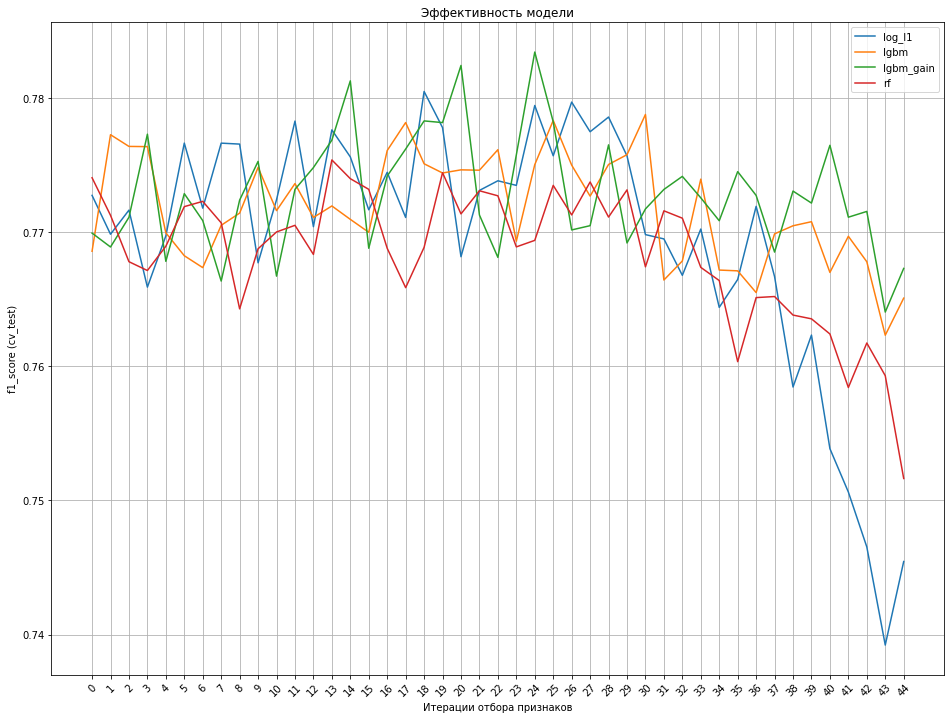

In [ ]:
# кривая метрик f1_macro
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('f1_score (cv_test)')
ax.grid(True)
plt.xticks(rotation = 45)
plt.show()

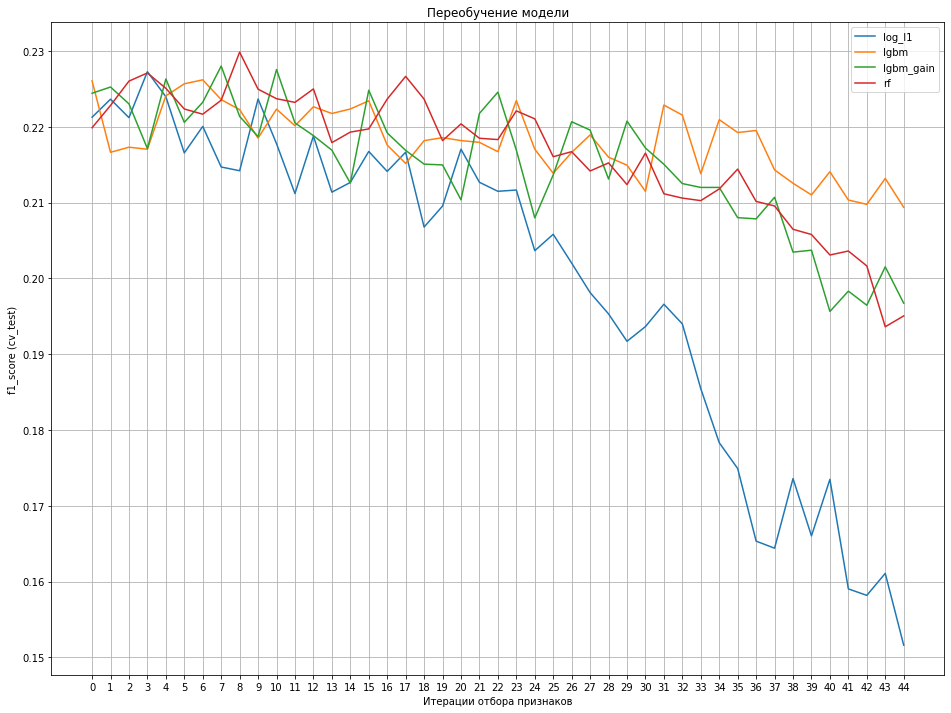

In [ ]:
# кривые переобучения
metric_fs_dif = metric_fs_train - metric_fs_test
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_dif.index:
    ax.plot(np.array(metric_fs_dif.columns), metric_fs_dif.loc[i, :], label=i)
ax.legend()
plt.title("Переобучение модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('f1_score (cv_test)')
ax.grid(True)
plt.show()

In [ ]:
new_feats = lgbm_gain_feats[24]
new_feats

['Страна_Родители_mean_СрБаллАттестата_editednum',
 'Изучаемый_Язык_mean_год_рождения_editednum',
 'Основания_mean_год_рождения_editednum',
 'Город_ПП_mean_возраст_постnum',
 'Город_Уч_Заведение_vc',
 'Уч_Заведение_mean_ID_editednum',
 'КодФакультета_bins0055_ord_cat_Город_ПП_ord_cat',
 'КодФакультета_mean_ID_edited',
 'Пол_mean_СрБаллАттестата_editednum',
 'Изучаемый_Язык_ord_cat_Город_ПП_ord_cat',
 'Основания_ord_cat_/_возраст_окон_log_bin',
 'КодФакультета_mean_Общежитие',
 'Год_Окончания_УЗ_mean_возраст_постnum',
 'Регион_ПП_mean_ID_editednum',
 'Город_ПП_mean_ID_editednum',
 'Изучаемый_Язык_ord_cat_/_Где_Находится_УЗ_ord_cat',
 'Уч_Заведение_mean_год_рождения_editednum',
 'Основания_bin_Уч_Заведение_ord_cat',
 'Код_группы_mean_Наличие_Матери',
 'возраст_окон_log_bin_КодФакультета_bins0055_ord_cat',
 'Основания_ord_cat_Уч_Заведение_ord_cat',
 'ID_edited',
 'Дата_Рождения_vc',
 'Где_Находится_УЗ_mean_ID_editednum',
 'месяц_рождения',
 'Код_группы_mean_пост_оконnum',
 'Основания_ord_

# Подбор Гиперпараметров

In [ ]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, - 1]:
        for num_leaves in [18, 21, 24, 27, 31, 35, 38, 41, 44]:
                    cl = LGBMClassifier(
                        n_jobs = -1, 
                        max_depth = max_depth, 
                        random_state=random_state,
                        num_leaves=num_leaves,
                        )
            
                    cv_res = cross_validate(
                        cl, X_train[new_feats], 
                        y_train[target], 
                        scoring= 'f1_macro', 
                        n_jobs = -1, 
                        cv = cv_splitter, 
                        return_train_score = True,
                         verbose = 0
                         )
                         
                    metric_table.loc[i, 'max_depth'] = max_depth
                    metric_table.loc[i, 'num_leaves'] = num_leaves
                    
                    metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
                    metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

                    # print (i)

                    i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [ ]:
metric_table.sort_values(by = 'cv_test', ascending = False).head(20)

,max_depth,num_leaves,cv_train,cv_test,cv_dif
20,5.0,24.0,0.931867,0.784119,0.147748
86,12.0,35.0,0.994665,0.783500,0.211165
94,-1.0,31.0,0.991450,0.783464,0.207986
29,6.0,24.0,0.951196,0.783375,0.167821
75,11.0,27.0,0.985033,0.783251,0.201782
22,5.0,31.0,0.934155,0.783133,0.151022
42,7.0,38.0,0.983411,0.782942,0.200469
28,6.0,21.0,0.948060,0.782796,0.165264
19,5.0,21.0,0.927541,0.782350,0.145192
26,5.0,44.0,0.932772,0.782327,0.150445


In [ ]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [3, 4, 5, 6, 7, 8]:
    cl = XGBClassifier(
        n_jobs = -1, 
        max_depth = max_depth, 
        random_state=random_state,
        )
    
    cv_res = cross_validate(
        cl, 
        X_train[new_feats], 
        y_train[target], 
        scoring= 'f1_macro', 
        n_jobs = -1, 
        cv = cv_splitter, 
        return_train_score = True, 
        verbose = 0)

    metric_table.loc[i, 'max_depth'] = max_depth
    
    metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
    metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

    # print (i)

    i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [ ]:
metric_table.sort_values(by = 'cv_test', ascending = False).head(20)

,max_depth,cv_train,cv_test,cv_dif
2,5.0,0.992247,0.778948,0.213299
5,8.0,1.000000,0.777842,0.222158
0,3.0,0.900312,0.777012,0.123299
4,7.0,1.000000,0.775297,0.224703
3,6.0,0.999556,0.774721,0.224834
1,4.0,0.959368,0.774542,0.184827


In [ ]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [4, 5, 6, 7, 8]:
        cl = CatBoostClassifier(
            max_depth = max_depth, 
            random_state=random_state,
            )
        
        cv_res = cross_validate(
            cl, 
            X_train[new_feats], 
            y_train[target], 
            scoring= 'f1_macro', 
            n_jobs = -1,
            cv = cv_splitter, 
            return_train_score = True, 
            verbose = 0)

        metric_table.loc[i, 'max_depth'] = max_depth
        metric_table.loc[i, 'random_state'] = random_state
        
        metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
        metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

        # print (i)

        i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

In [ ]:
metric_table.sort_values(by = 'cv_test', ascending = False).head()

,max_depth,random_state,cv_train,cv_test,cv_dif
3,7.0,512.0,0.981579,0.770607,0.210972
4,8.0,512.0,0.996639,0.769547,0.227092
2,6.0,512.0,0.959975,0.767606,0.192369
1,5.0,512.0,0.931950,0.763305,0.168645
0,4.0,512.0,NaN,NaN,NaN


# Voting CV

In [ ]:
cl1 = LGBMClassifier (
    n_jobs=-1,
    max_depth = 5,
    num_leaves = 24,
    random_state= random_state,
    )

cl2 = XGBClassifier (
    max_depth = 5,
    random_state= random_state,
    )

cl3 = CatBoostClassifier (
    max_depth = 7,
    random_state= random_state,
    verbose = 0
    )

In [ ]:
pred1 = cross_val_predict(cl1, X_train[new_feats], y_train[target], cv = cv_splitter)
f1_score(y_train, pred1, average = 'macro')

0.7842319822371288

In [ ]:
pred2 = cross_val_predict(cl2, X_train[new_feats], y_train[target], cv = cv_splitter, n_jobs = -1)
f1_score(y_train, pred2, average = 'macro')

0.7790609779319625

In [ ]:
pred3 = cross_val_predict(cl3, X_train[new_feats], y_train[target], cv = cv_splitter, n_jobs = -1)
f1_score(y_train, pred3, average = 'macro')

0.7707592415881676

In [ ]:
# Голосование с абсолютным весом класса - 1
# Классы 3 и 4 выбираются по большинству
pred_voting = voting_cv(cl1, cl2, cl3, X_train, y_train, cv_splitter, new_feats)
f1_score(y_train, pred_voting, average = 'macro')

0.7972075086660307

# Предсказание и создание файла с ответом

In [ ]:
prediction = voting_pred (cl1, cl2, cl3, X_train, y_train, X_sub, new_feats)

In [ ]:
df_test = pd.read_csv("test_dataset_test.csv")
df_submission = pd.read_csv("sample_submission.csv")

In [ ]:
df_submission["Статус"] = new_sub['Статус']
df_submission.head(10)

,ID,Статус
0,64996,4.0
1,71837,4.0
2,86587,3.0
3,73673,-1.0
4,54709,4.0
5,56072,3.0
6,77774,3.0
7,90707,3.0
8,76202,4.0
9,74726,4.0


In [ ]:
# df_submission.to_csv("final_submission.csv", index = False)